In [1]:
%cd ..
%ls

/home/nas3_userJ/dmkim/OnlineTSAD
cfgs/         data/  Exp/   models/   plots/    test.py*   utils/  wandb/
checkpoints/  EDA/   logs/  outputs/  results/  train.py*  Vis/


In [2]:
import torch
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt

from utils.metrics import get_summary_stats

from models.MLP import MLP

import wandb
import hydra
from omegaconf import DictConfig

from utils.logger import make_logger
from utils.argpass import prepare_arguments, configure_exp_id
from utils.tools import SEED_everything, plot_anomaly

import warnings
from data.load_data import DataFactory
from Exp.ReconBaselines import *

from easydict import EasyDict as edict
import yaml
import re

warnings.filterwarnings("ignore")

In [3]:
# load yaml
cfg = {}
loader = yaml.SafeLoader
loader.add_implicit_resolver(
    u'tag:yaml.org,2002:float',
    re.compile(u'''^(?:
     [-+]?(?:[0-9][0-9_]*)\\.[0-9_]*(?:[eE][-+]?[0-9]+)?
    |[-+]?(?:[0-9][0-9_]*)(?:[eE][-+]?[0-9]+)
    |\\.[0-9_]+(?:[eE][-+][0-9]+)?
    |[-+]?[0-9][0-9_]*(?::[0-5]?[0-9])+\\.[0-9_]*
    |[-+]?\\.(?:inf|Inf|INF)
    |\\.(?:nan|NaN|NAN))$''', re.X),
    list(u'-+0123456789.'))

# get cfg
model = "MLP"
with open("cfgs/test_defaults.yaml", "r") as file:
    basic_config = yaml.load(file, Loader=loader)
    cfg.update(basic_config)
with open(f"cfgs/model/{model}.yaml", "r") as file:
    model_config = yaml.load(file, Loader=loader)
    cfg.update({"model": model_config})
cfg['dataset'] = 'WADI'

In [4]:
args = prepare_arguments(cfg)
args.model.latent_dim = 128
args.window_size = 12
args.eval_batch_size = 1
args.scaler = "std"
args.dataset = "WADI"
print(args)

logger = make_logger(os.path.join(args.log_path, f'{args.exp_id}.log'))
logger.info(f"Configurations: {args}")

# Data
logger.info(f"Preparing {args.dataset} dataset...")
datafactory = DataFactory(args, logger)
train_dataset, train_loader, test_dataset, test_loader = datafactory()
args.num_channels = train_dataset.X.shape[1]
train_X, train_y, test_X, test_y = train_dataset.X, train_dataset.y, test_dataset.X, test_dataset.y

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

[2023-03-18 15:28:58,504] Configurations: {'exp_id': 'MLP_WADI', 'dataset': 'WADI', 'batch_size': 64, 'eval_batch_size': 1, 'window_size': 12, 'stride': 1, 'eval_stride': 12, 'scaler': 'std', 'load_previous_error': True, 'lr': 0.001, 'epochs': 30, 'log_freq': 10, 'checkpoint_path': './checkpoints/MLP_WADI', 'log_path': './logs/MLP_WADI', 'output_path': './outputs/MLP_WADI', 'plot_path': './plots/MLP_WADI', 'result_path': './results/MLP_WADI', 'thresholding': 'oracle', 'defaults': [{'model': 'OCSVM'}], 'model': {'name': 'MLP', 'latent_dim': 128}, 'home_dir': '.', 'device': device(type='cuda')}
[2023-03-18 15:28:58,505] Preparing WADI dataset...
[2023-03-18 15:28:58,507] current location: /home/nas3_userJ/dmkim/OnlineTSAD
[2023-03-18 15:28:58,508] home dir: .
[2023-03-18 15:28:58,509] Preparing WADI ...


{'exp_id': 'MLP_WADI', 'dataset': 'WADI', 'batch_size': 64, 'eval_batch_size': 1, 'window_size': 12, 'stride': 1, 'eval_stride': 12, 'scaler': 'std', 'load_previous_error': True, 'lr': 0.001, 'epochs': 30, 'log_freq': 10, 'checkpoint_path': './checkpoints/MLP_WADI', 'log_path': './logs/MLP_WADI', 'output_path': './outputs/MLP_WADI', 'plot_path': './plots/MLP_WADI', 'result_path': './results/MLP_WADI', 'thresholding': 'oracle', 'defaults': [{'model': 'OCSVM'}], 'model': {'name': 'MLP', 'latent_dim': 128}, 'home_dir': '.', 'device': device(type='cuda')}


[2023-03-18 15:29:22,686] train: X - (784571, 123), y - (784571,) test: X - (172803, 123), y - (172803,)
[2023-03-18 15:29:22,867] Complete.
[2023-03-18 15:29:22,869] Preparing dataloader...
[2023-03-18 15:29:24,962] total train dataset- 12259, batch_X - torch.Size([64, 12, 123]), batch_y - torch.Size([64, 12])
[2023-03-18 15:29:24,964] total test dataset- 14400, batch_X - torch.Size([1, 12, 123]), batch_y - torch.Size([1, 12])
[2023-03-18 15:29:24,965] Complete.


(784571, 123) (784571,) (172800, 123) (172800,)


## Visualize

In [ ]:
for c in range(args.num_channels):
    dataset = "WADI"
    datafactory.visualize_dataset(train_dataset.X, train_dataset.y, test_dataset.X, test_dataset.y, dataset_name=dataset, feature_idx=c)

## Load Model

In [5]:
tester = MLP_Tester(
    args=args,
    logger=logger,
    train_loader=train_loader,
    test_loader=test_loader,
)
tester.load(os.path.join("./checkpoints/MLP_WADI", f"best.pth"))

[2023-03-18 15:29:30,552] loading: ./checkpoints/MLP_WADI/best.pth @Trainer - torch.load_state_dict


In [6]:
next(iter(tester.model.parameters())).device, next(iter(tester.model.parameters())).requires_grad

(device(type='cuda', index=0), True)

## Training statistics

In [7]:
train_iterator = tqdm(
    tester.train_loader,
    total=len(tester.train_loader),
    desc="calculating reconstruction errors",
    leave=True
)

recon_errors = []
with torch.no_grad():
    for i, batch_data in enumerate(train_iterator):
        X = batch_data[0].to(args.device)
        B, L, C = X.shape
        Xhat = tester.model(X.reshape(B, L*C)).reshape(B, L, C)
        recon_error = torch.nn.functional.mse_loss(Xhat, X, reduction='none')
        recon_errors.append(recon_error)

recon_errors = torch.cat(recon_errors, axis=0)

train_error_dist = recon_errors.mean(dim=(1, 2))

print(f"{recon_errors.shape}, {train_error_dist.shape}")

calculating reconstruction errors: 100%|██████████| 12259/12259 [00:27<00:00, 451.97it/s]

torch.Size([784560, 12, 123]), torch.Size([784560])


## Test: static threshold inference

In [9]:
eval_iterator = tqdm(
    tester.test_loader,
    total=len(tester.test_loader),
    desc="calculating reconstruction errors",
    leave=True
)

anoscs_prev = []
Xhats_prev = []
with torch.no_grad():
    for i, batch_data in enumerate(eval_iterator):
        X, y = batch_data[0].to(args.device), batch_data[1].to(args.device)
        B, L, C = X.shape
        Xhat = tester.model(X.reshape(B, L*C)).reshape(B, L, C)
        Xhats_prev.append(Xhat)        
        e = F.mse_loss(Xhat, X, reduction='none')
        anosc = e.mean(dim=2)
        anoscs_prev.append(anosc)

Xhats_prev = torch.cat(Xhats_prev, axis=0).detach().cpu().numpy()
anoscs_prev = torch.cat(anoscs_prev, axis=0).reshape(-1).detach().cpu().numpy()

calculating reconstruction errors: 100%|██████████| 14400/14400 [00:09<00:00, 1463.39it/s]


In [10]:
th_q95 = torch.quantile(train_error_dist, 0.95).item()
th_q99 = torch.quantile(train_error_dist, 0.99).item()
th_q100 = torch.max(train_error_dist).item()
th_best_static = tester.get_best_static_threshold(gt=test_y, anomaly_scores=anoscs_prev)
th_q95, th_q99, th_q100, th_best_static

[2023-03-18 15:25:49,592] Best threshold found at: 0.16100528836250305, with fpr: 0.6067570306406344, tpr: 0.7603488022451639
tn: 64029 fn: 2391
fp: 98794 tp: 7586


(0.09023045748472214, 0.29068630933761597, 221.101806640625, 0.16100529)

In [11]:
# 95
print(get_summary_stats(test_dataset.y, anoscs_prev > th_q95))
# 99
print(get_summary_stats(test_dataset.y, anoscs_prev > th_q99))
# 100
print(get_summary_stats(test_dataset.y, anoscs_prev > th_q100))
# oracle
print(get_summary_stats(test_dataset.y, anoscs_prev > th_best_static))

{'Accuracy': 0.33696180555555555, 'Precision': 0.06746340253080804, 'Recall': 0.8175804350005011, 'F1': 0.12464186664833024, 'tn': 50070, 'fp': 112753, 'fn': 1820, 'tp': 8157}
{'Accuracy': 0.42765625, 'Precision': 0.06553772792120229, 'Recall': 0.6722461661822191, 'F1': 0.11943195477006632, 'tn': 67192, 'fp': 95631, 'fn': 3270, 'tp': 6707}
{'Accuracy': 0.44232060185185185, 'Precision': 0.041629525871216946, 'Recall': 0.3932043700511176, 'F1': 0.07528811184785007, 'tn': 72510, 'fp': 90313, 'fn': 6054, 'tp': 3923}
{'Accuracy': 0.41443287037037035, 'Precision': 0.07130166668233393, 'Recall': 0.7602485717149444, 'F1': 0.13037574340816116, 'tn': 64029, 'fp': 98794, 'fn': 2392, 'tp': 7585}


### Label-guided Online learning

In [12]:
init_thr = torch.quantile(train_error_dist, 0.95).item()
thr = torch.tensor(init_thr, requires_grad=True)
thr

tensor(0.0902, requires_grad=True)

In [14]:
eval_iterator = tqdm(
    tester.test_loader,
    total=len(tester.test_loader),
    desc="calculating reconstruction errors",
    leave=True
)

lr = 1e-04
TH_optimizer = torch.optim.SGD([thr]+[p for p in tester.model.parameters()], lr=lr)
bce = torch.nn.BCELoss()

Xs = []
Xhats = []
yhats = []
anoscs=[]
thrs = []
preds = []
for i, batch_data in enumerate(eval_iterator):
    X, y = batch_data[0].to(tester.args.device), batch_data[1].to(tester.args.device)
    Xs.append(X)
    
    # infer
    B, L, C = X.shape
    Xhat = tester.model(X.reshape(B, L*C)).reshape(B, L, C)
    Xhats.append(Xhat)
    
    e = F.mse_loss(Xhat, X, reduction='none')
    anosc = e.mean(dim=2)
    anoscs.append(anosc)
    thrs.append(thr.item())
    pred = (anosc > thr)
    preds.append(pred)
    
    # update
    TH_optimizer.zero_grad()
    yhat = torch.sigmoid(anosc-thr)
    yhats.append(yhat)
    cls_loss = bce(yhat, y.float())
    mask = ((y == 0).unsqueeze(2))
    recon_loss = (e*mask).mean()
    loss = cls_loss + recon_loss
    
    eval_iterator.set_description("loss: {loss.item}")
    
    loss.backward()
    TH_optimizer.step()
    
Xs = torch.cat(Xs, axis=0).detach().cpu().numpy()    
Xhats = torch.cat(Xhats, axis=0).detach().cpu().numpy()
yhats = torch.cat(yhats, axis=0).detach().cpu().numpy()

anoscs = torch.cat(anoscs, axis=0).detach().cpu().numpy()
thrs = np.repeat(np.array(thrs), args.window_size*args.eval_batch_size)
preds = torch.cat(preds).reshape(-1).detach().cpu().numpy()

calculating reconstruction errors:   0%|          | 0/14400 [00:00<?, ?it/s]


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [29]:
print(test_y.shape, preds.shape)
get_summary_stats(test_y, preds)

(427608,) (427608,)


{'Accuracy': 0.8718545957980206,
 'Precision': 0.02830188679245283,
 'Recall': 5.484861781483107e-05,
 'F1': 0.00010948505528995293,
 'tn': 372809,
 'fp': 103,
 'fn': 54693,
 'tp': 3}

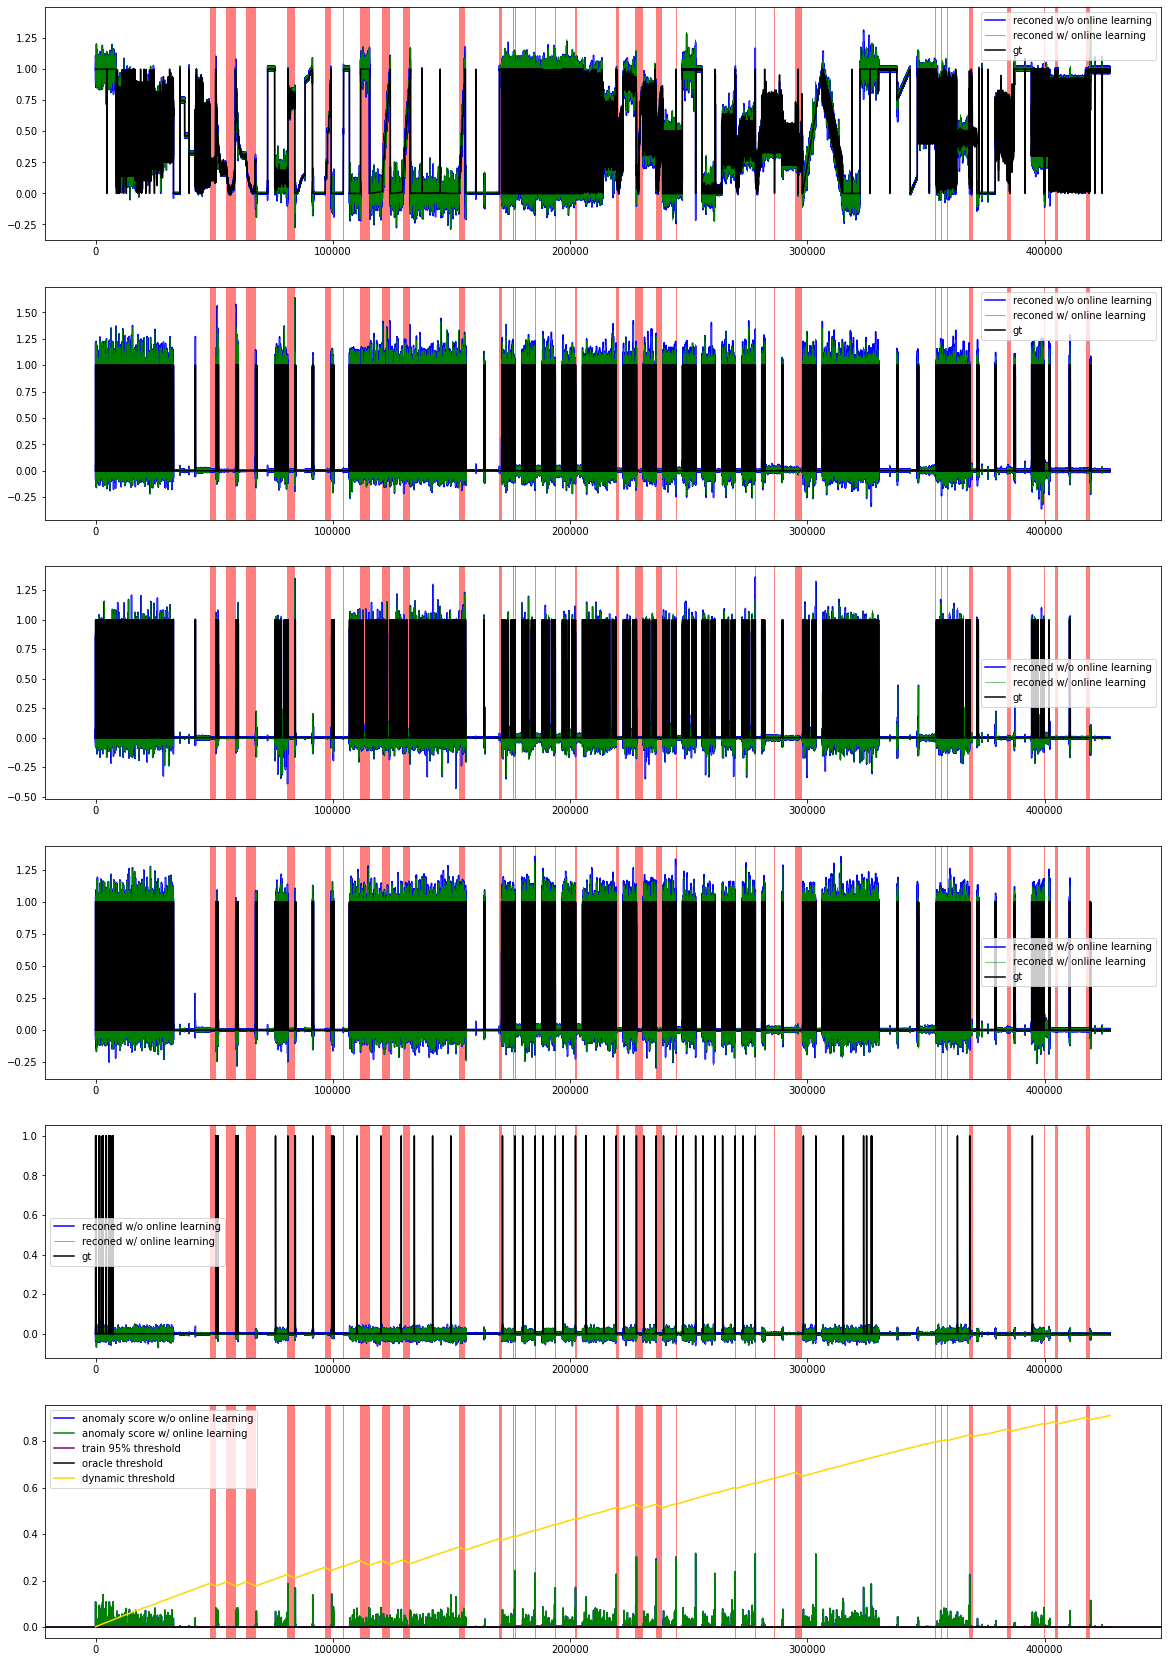

In [30]:
# plot abnormal
test_X, test_y = test_dataset.X, test_dataset.y

B, L, C = Xhats.shape

fig, ax = plt.subplots(6, 1, figsize=(20, 30))

for c in range(min(args.num_channels, 5)):
    # gt
    plot_anomaly(ax[c], test_y)
    
    # reconed
    ax[c].plot(Xhats_prev[:,:,c].reshape(-1), color="blue", label="reconed w/o online learning")
    ax[c].plot(Xhats[:,:,c].reshape(-1), linewidth=0.5, color="green", label="reconed w/ online learning")
    ax[c].plot(test_X[:, c], color="black", label="gt")
    ax[c].legend()

#ax[5].set_ylim([-1, 20])
ax[5].plot(anoscs_prev.reshape(-1), color="blue", label="anomaly score w/o online learning")
ax[5].plot(anoscs.reshape(-1), color="green", label="anomaly score w/ online learning")
ax[5].axhline(th_q95, color="purple", label="train 95% threshold")
ax[5].axhline(th_best_static, color="black", label="oracle threshold")
ax[5].plot(thrs, color="gold",label="dynamic threshold")
ax[5].legend()
plot_anomaly(ax[5], test_y)

plt.show()

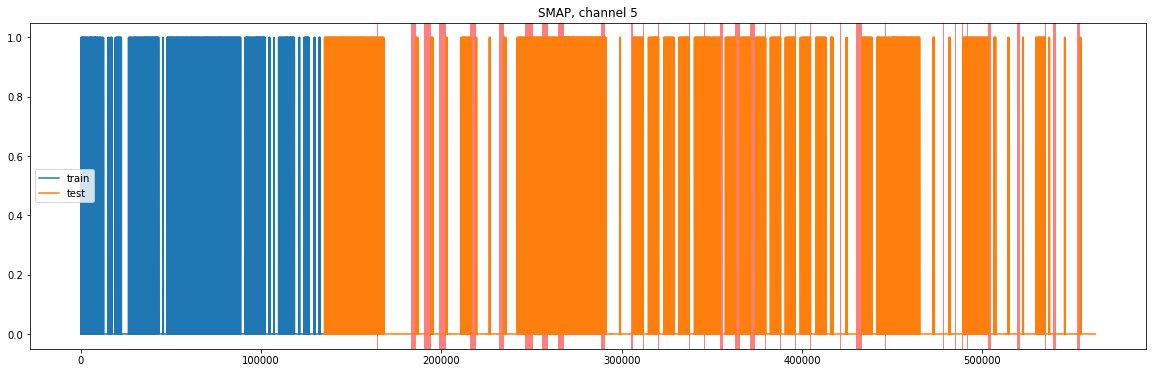

In [31]:
c=5
plt.figure(figsize=(20, 6))
plt.title(f"{args.dataset}, channel {c}")
plt.plot(train_X[:, c], label="train", color="#1f77b4")
plt.plot(range(len(train_X), len(train_X)+len(test_X)), test_X[:, c], label="test", color="#ff7f0e")
lb = np.concatenate([np.zeros(len(train_X)), test_y])
plot_anomaly(plt, lb)
plt.legend()
plt.show()

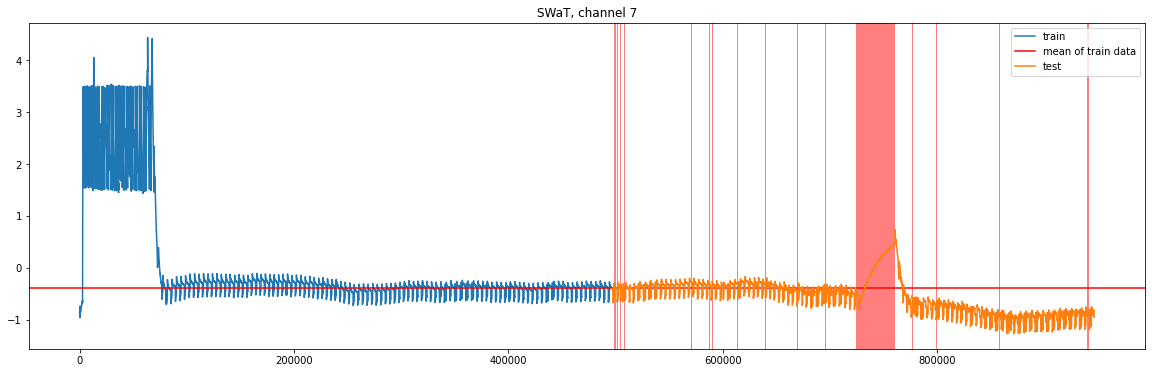

In [17]:
c=7
plt.figure(figsize=(20, 6))
#plt.ylim(-6, 6)
plt.title(f"{args.dataset}, channel {c}")

plt.plot(train_X[:, c], label="train", color="#1f77b4")
plt.axhline(train_X[100000:, c].mean(), color = 'r', label="mean of train data")
plt.plot(range(len(train_X), len(train_X)+len(test_X)), test_X[:, c], label="test", color="#ff7f0e")

lb = np.concatenate([np.zeros(len(train_X)), test_y])
plot_anomaly(plt, lb)
plt.legend()
plt.show()

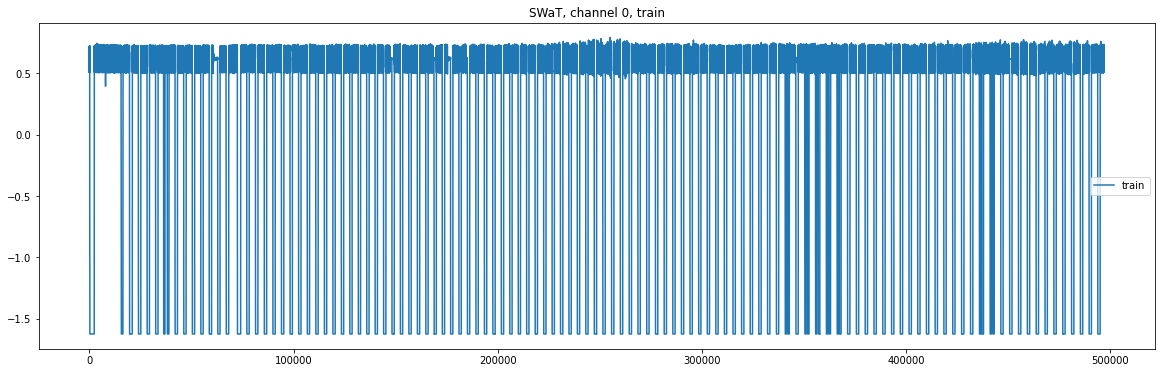

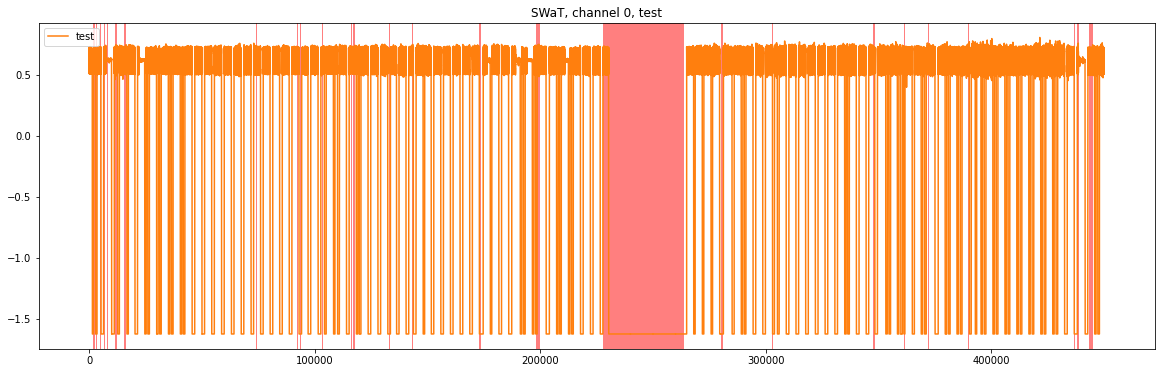

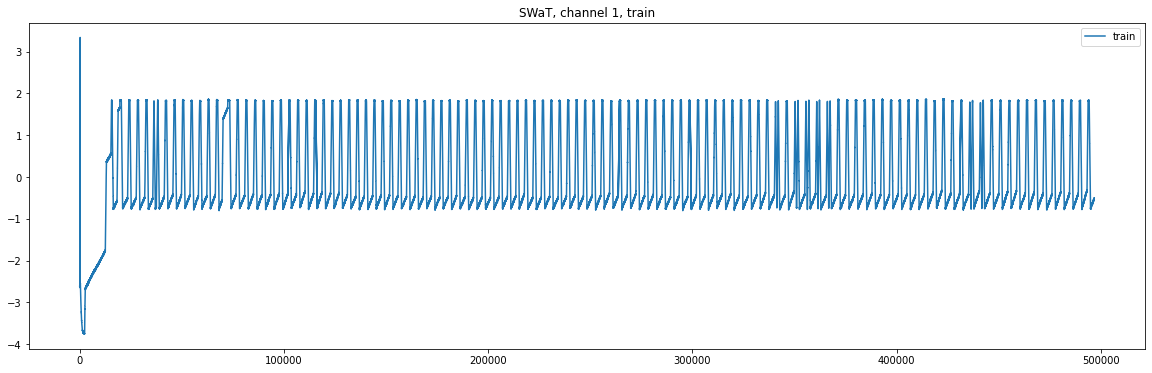

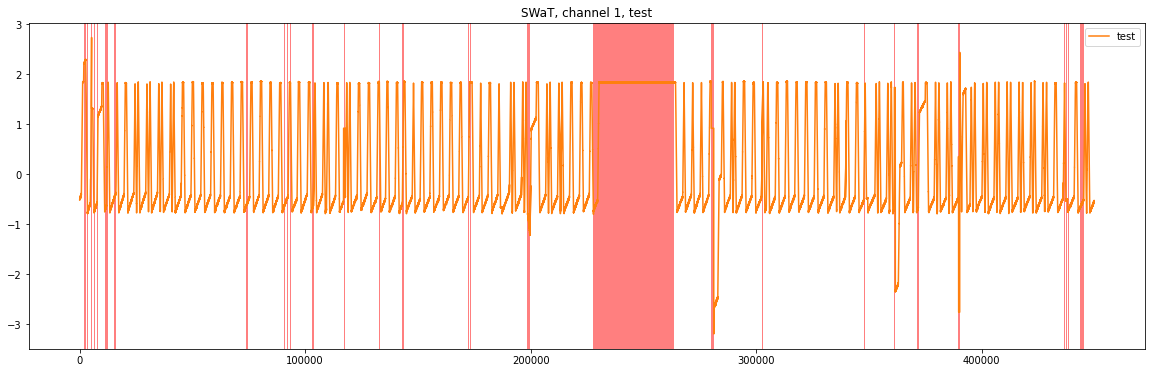

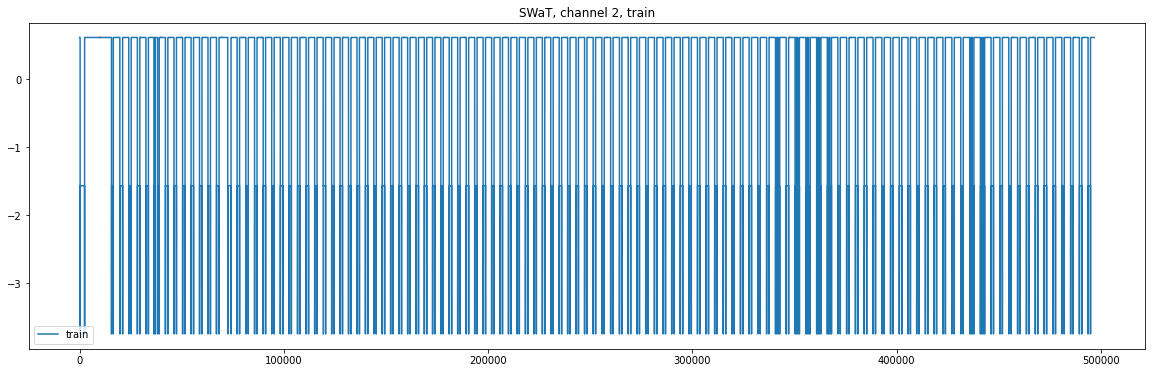

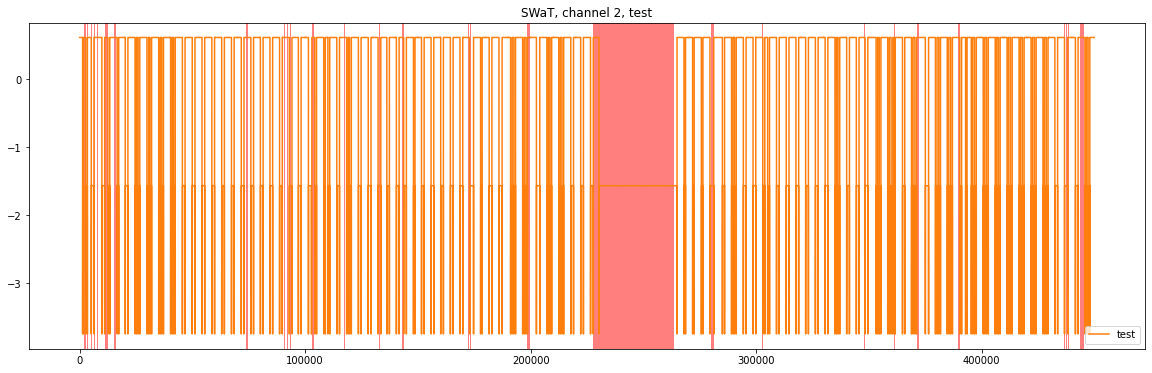

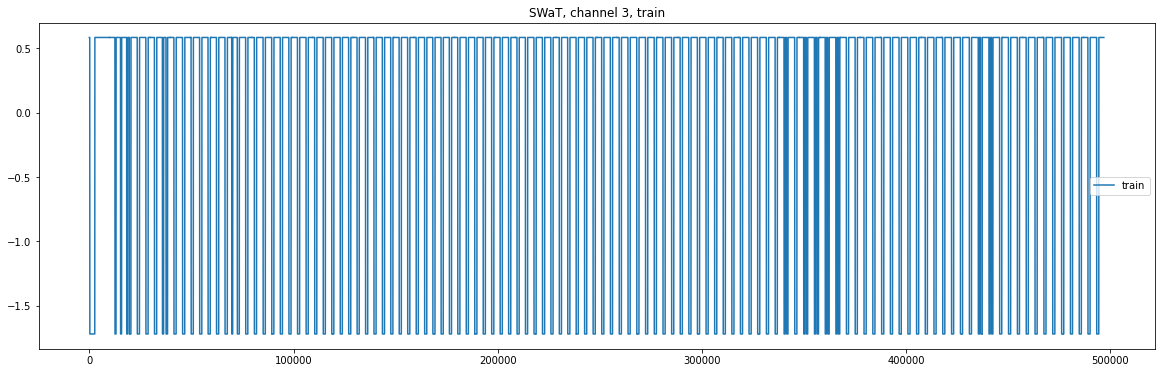

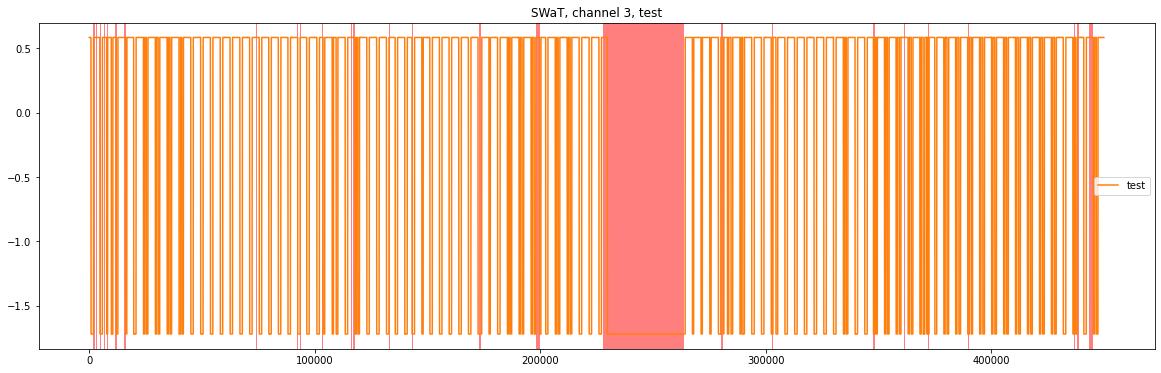

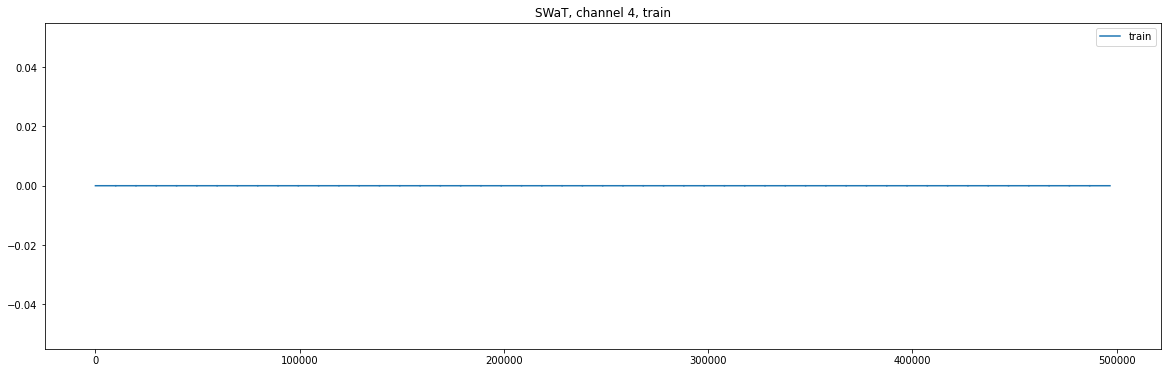

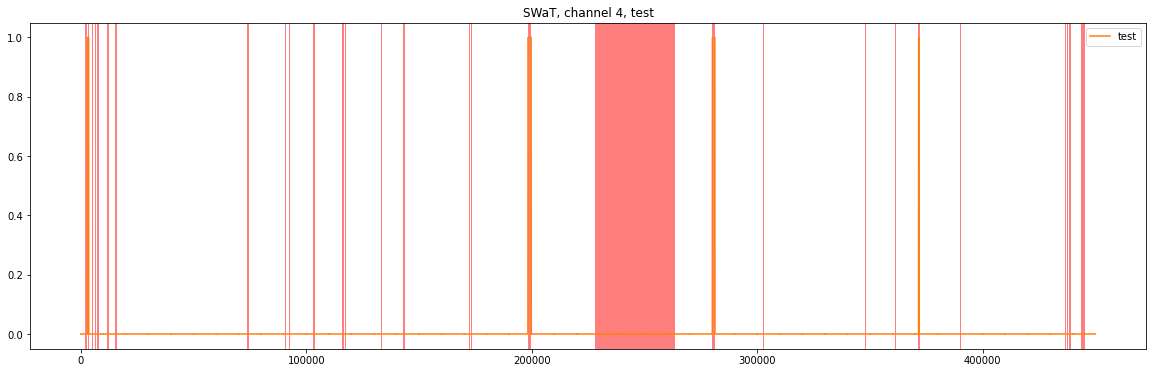

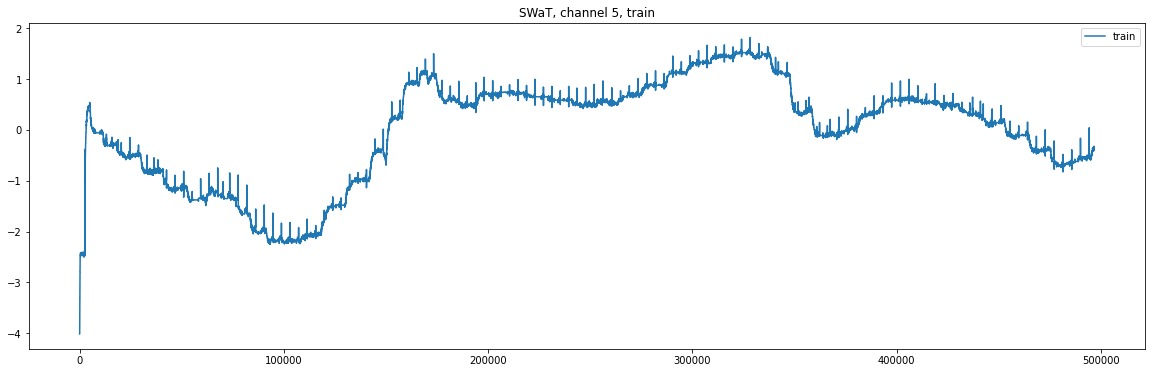

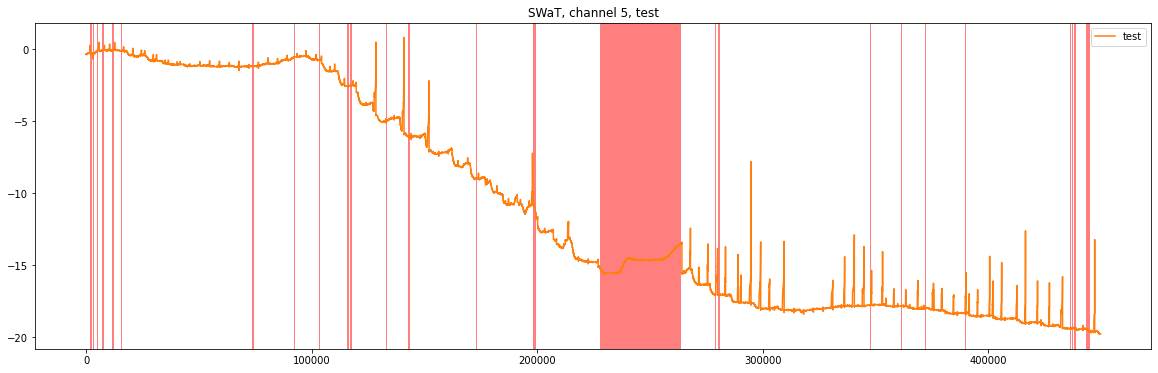

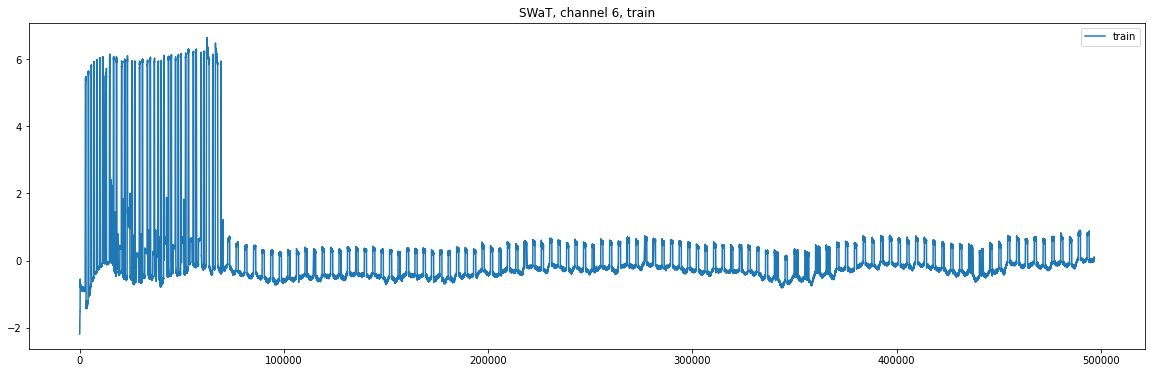

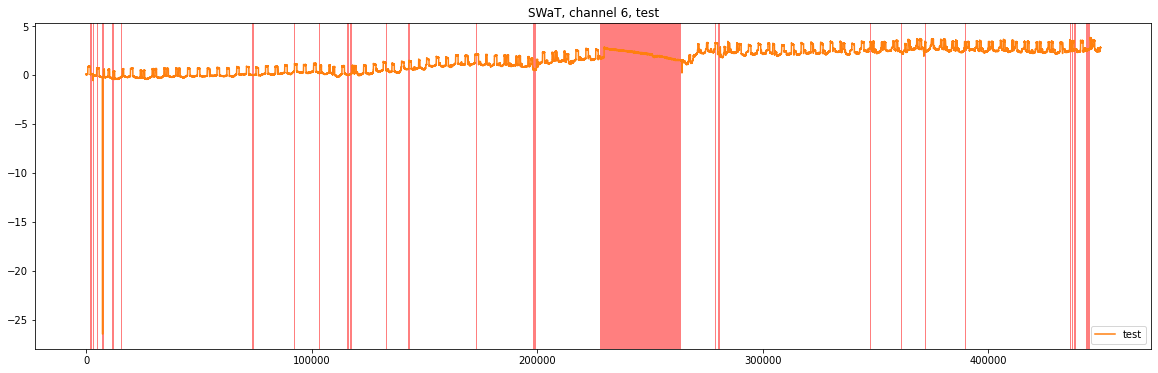

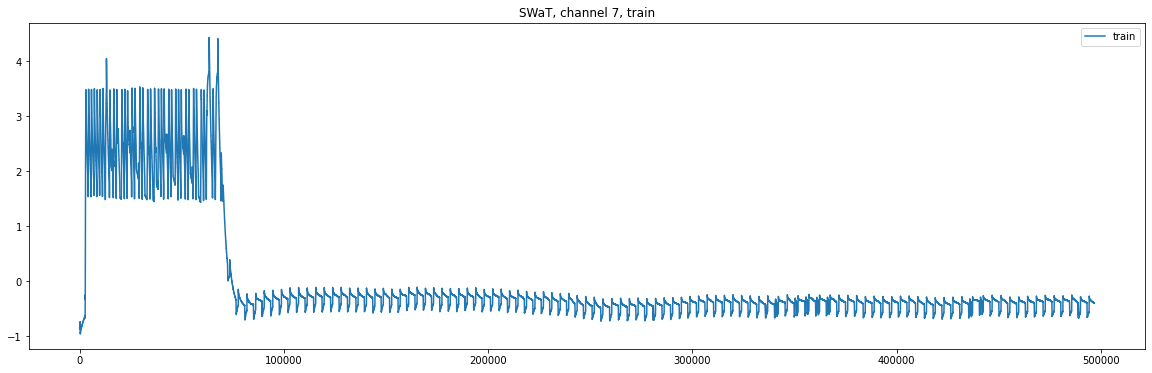

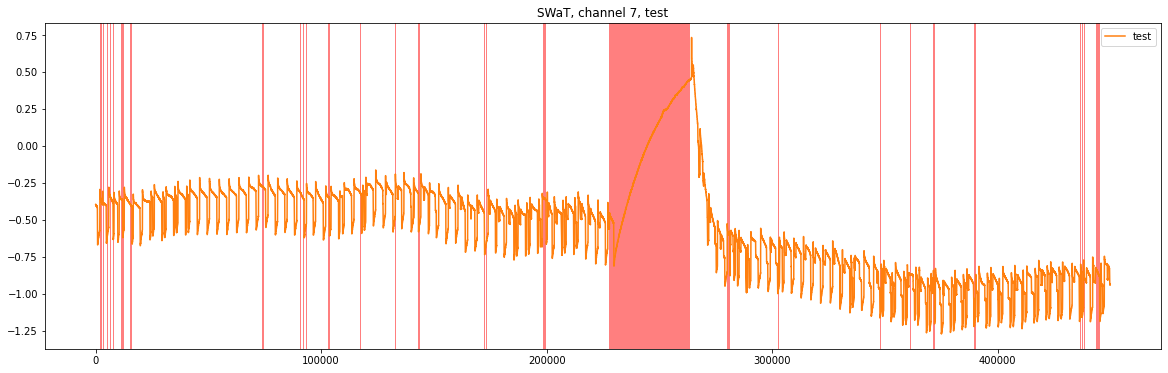

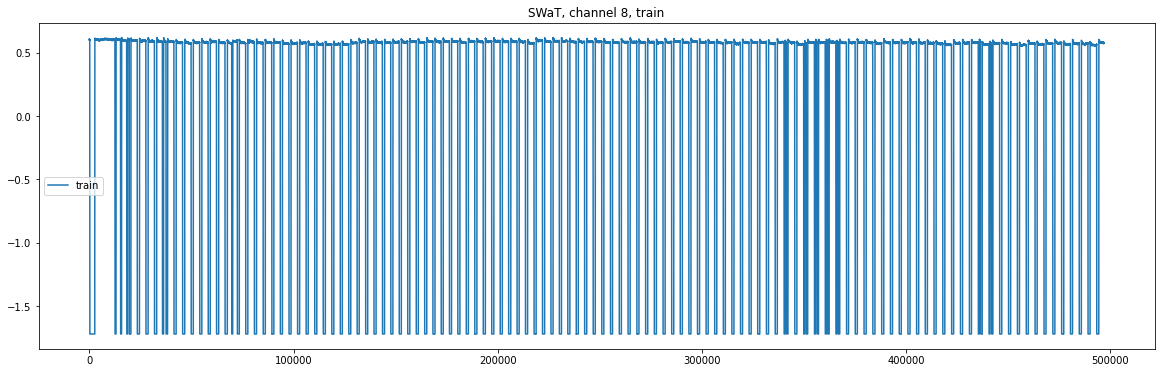

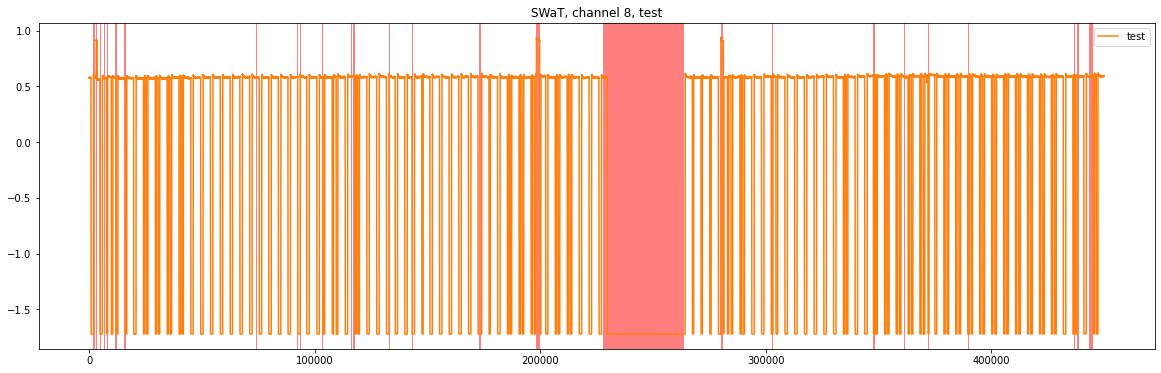

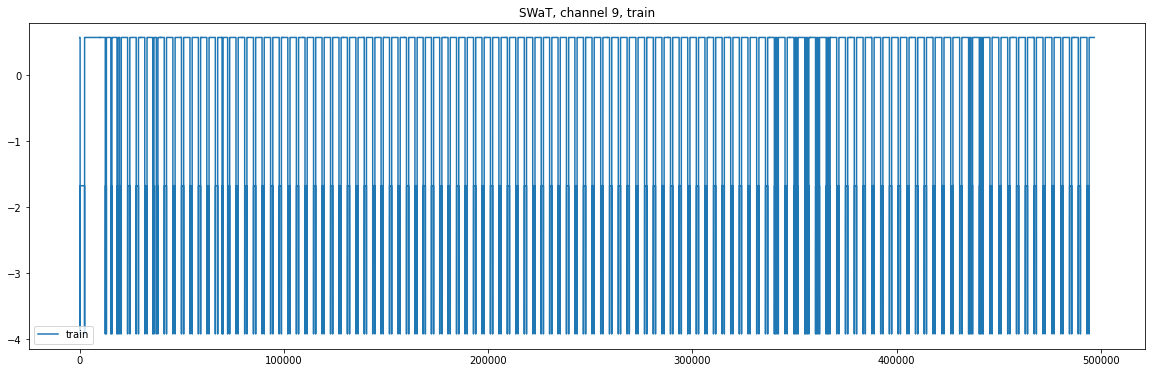

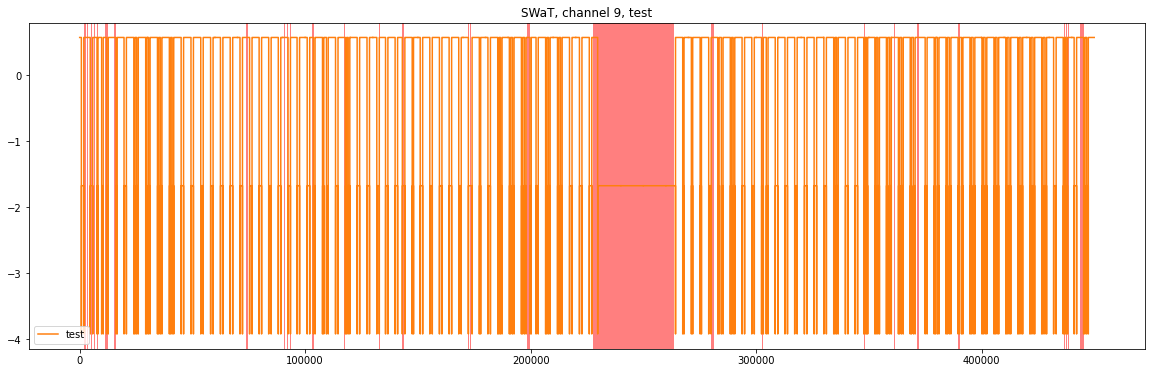

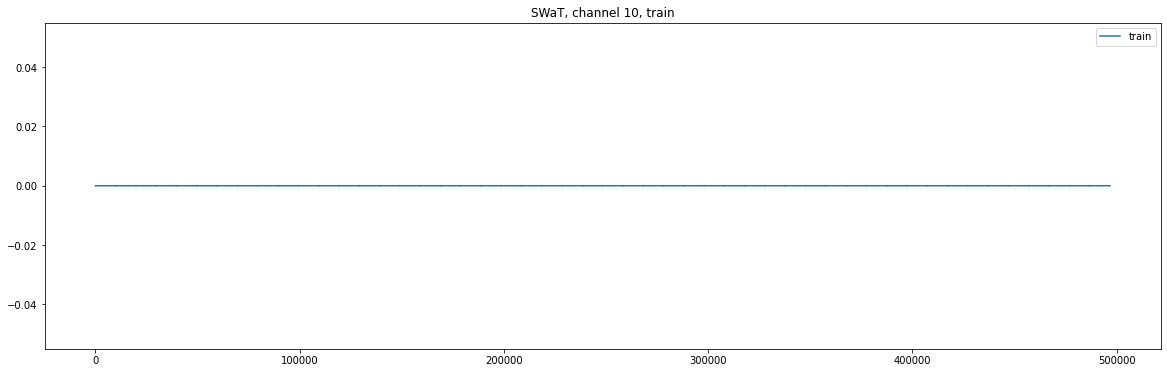

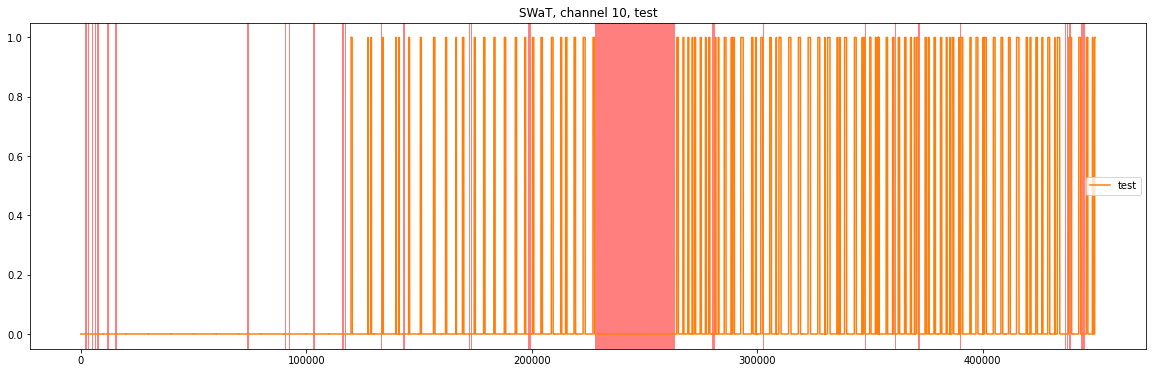

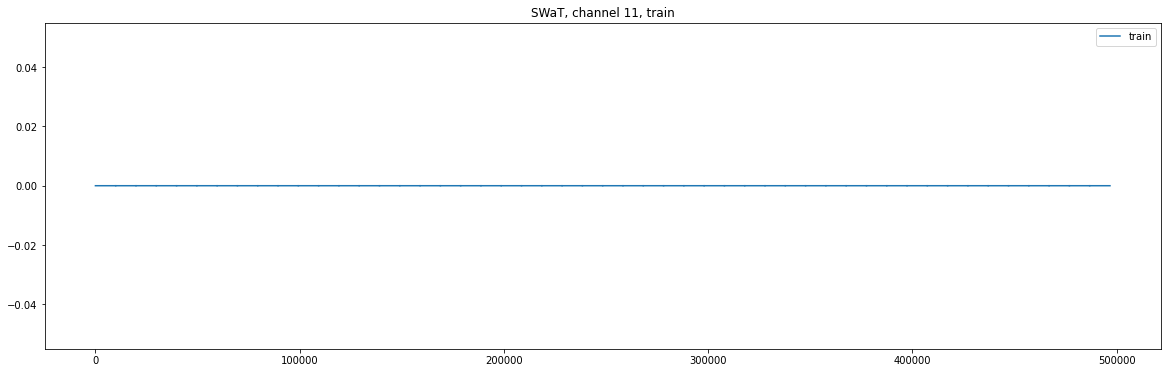

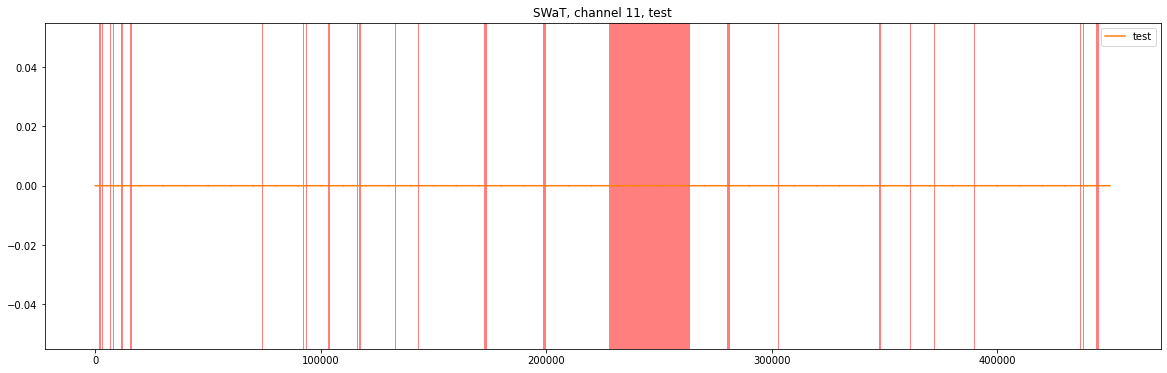

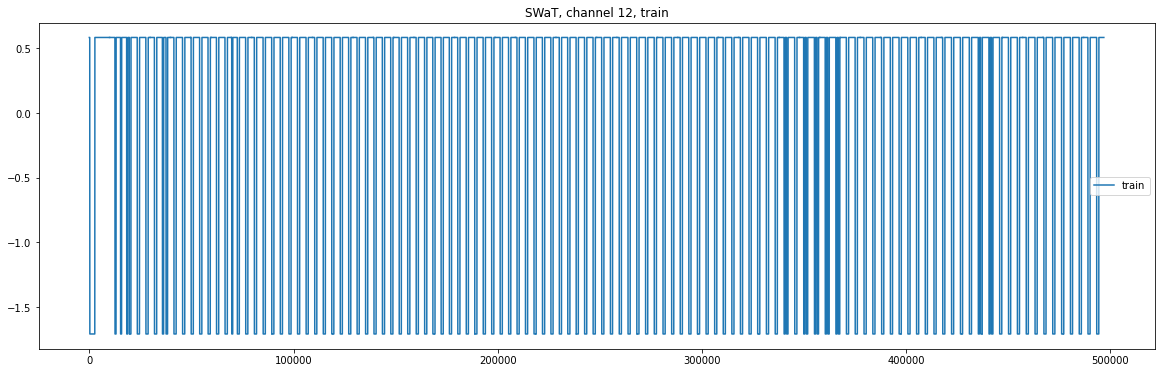

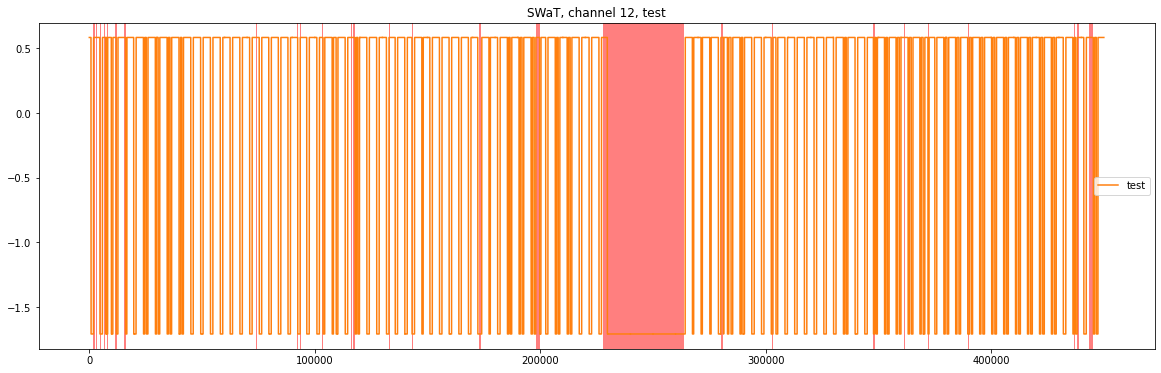

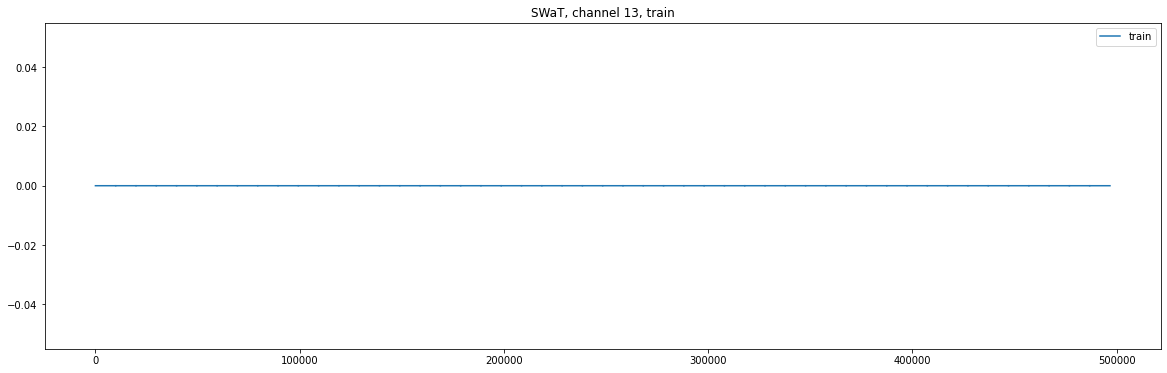

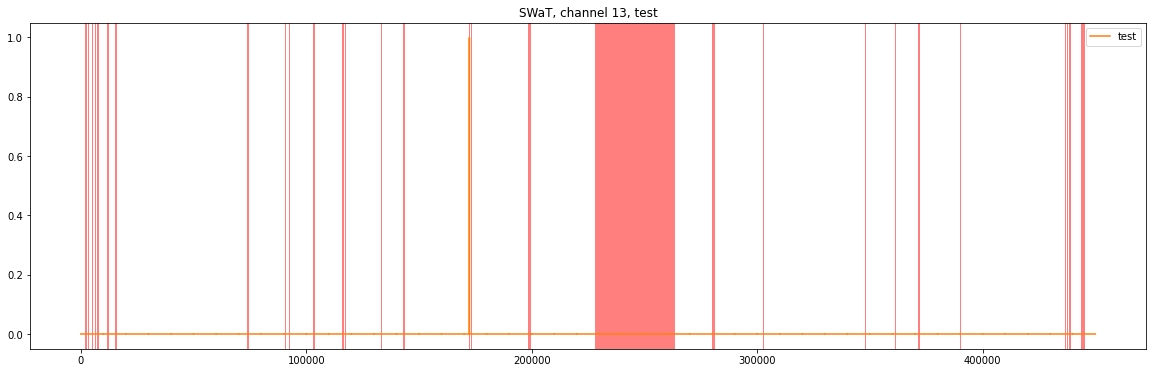

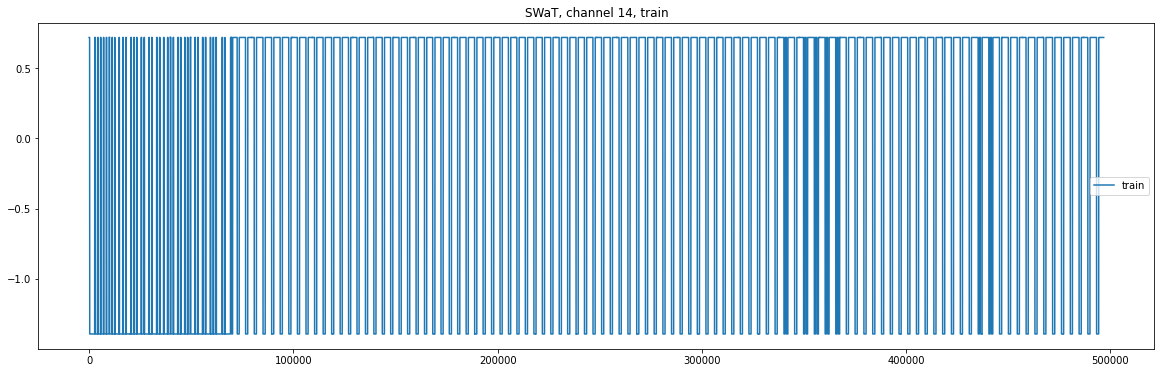

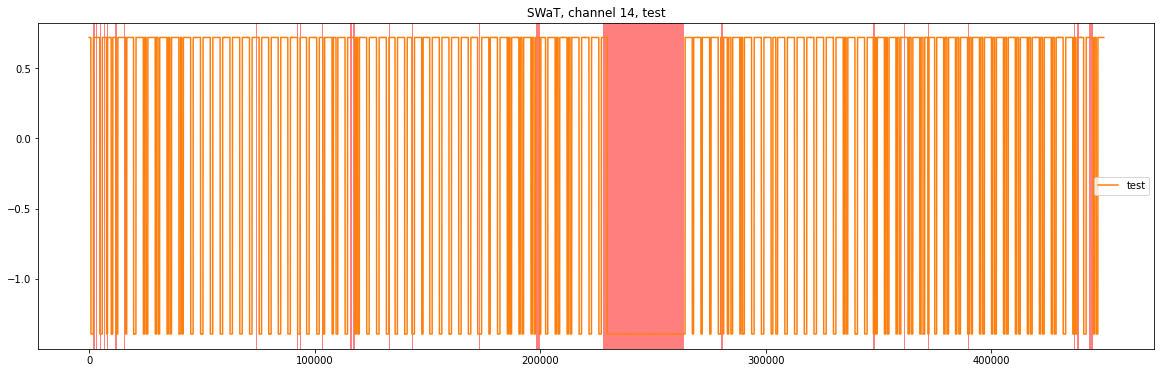

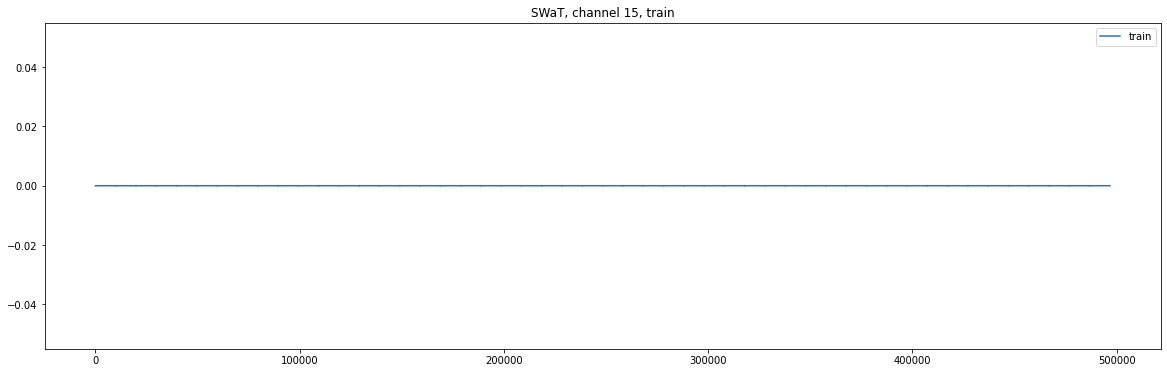

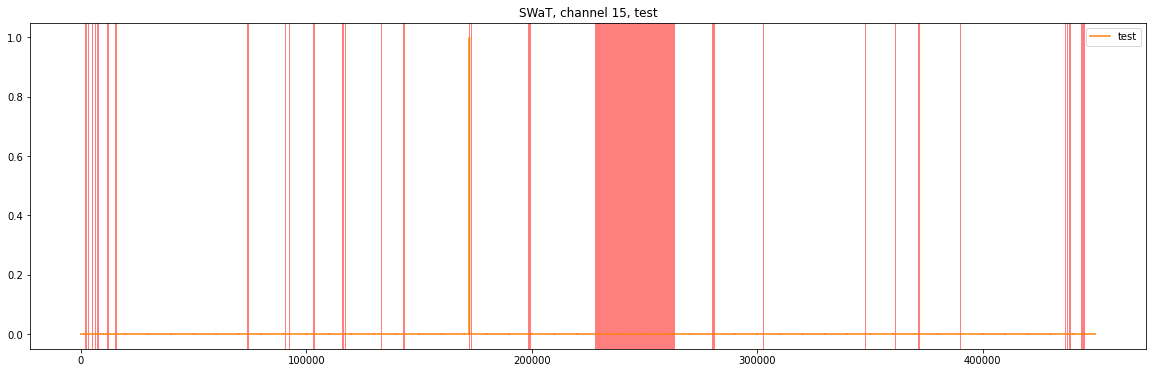

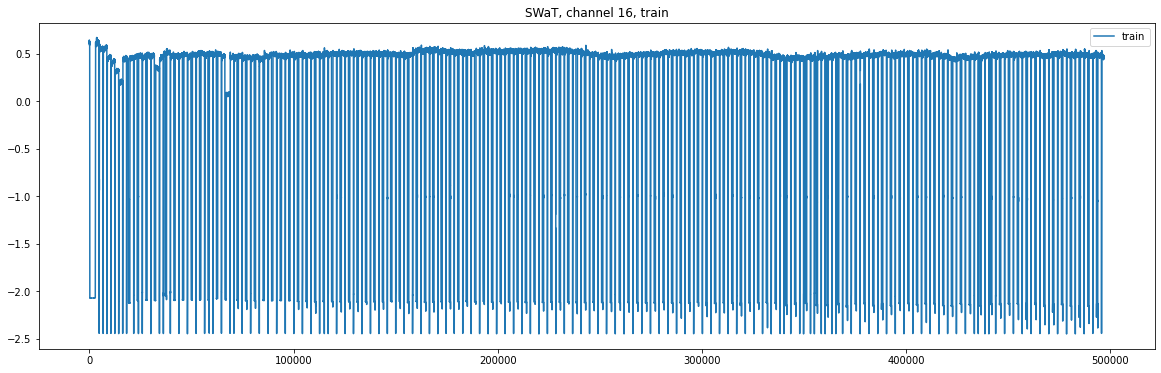

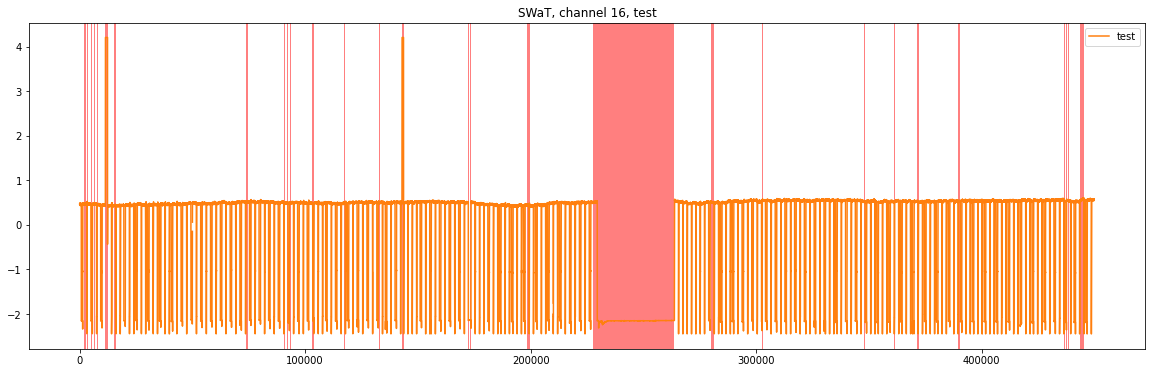

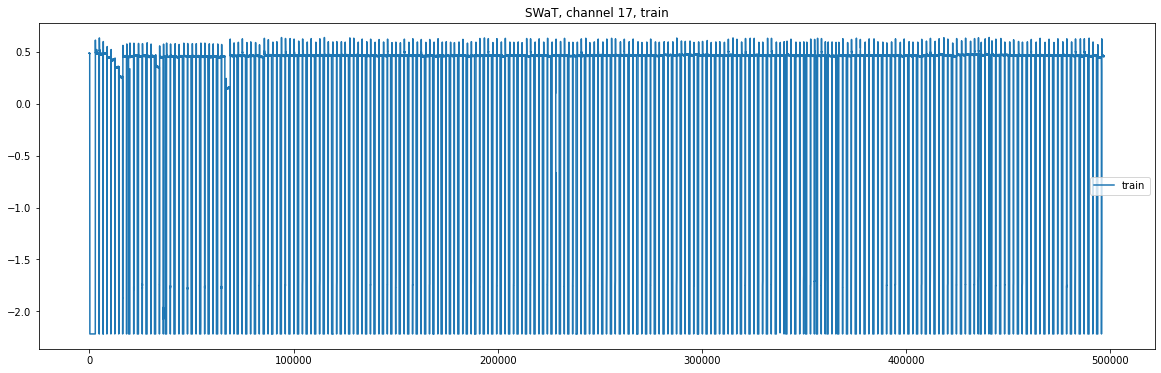

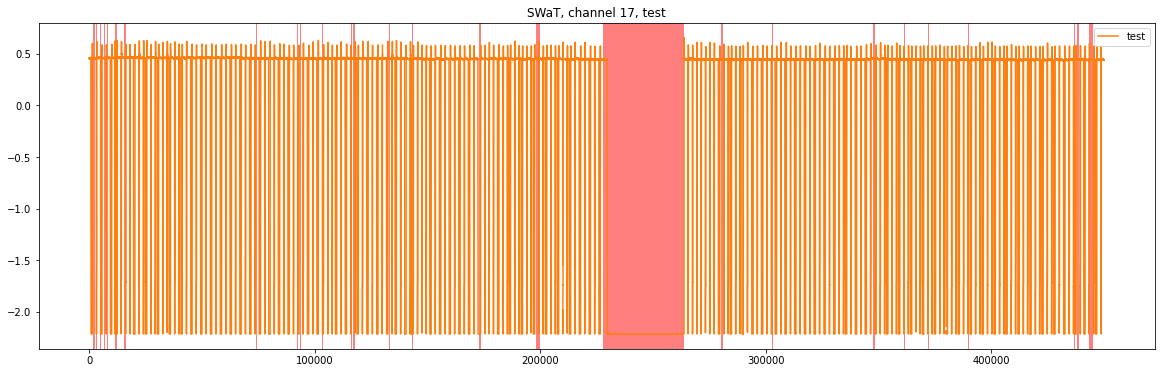

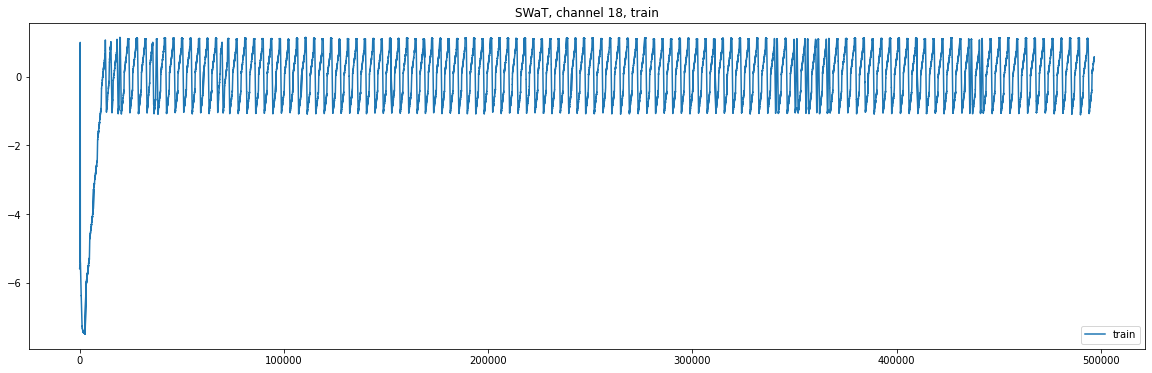

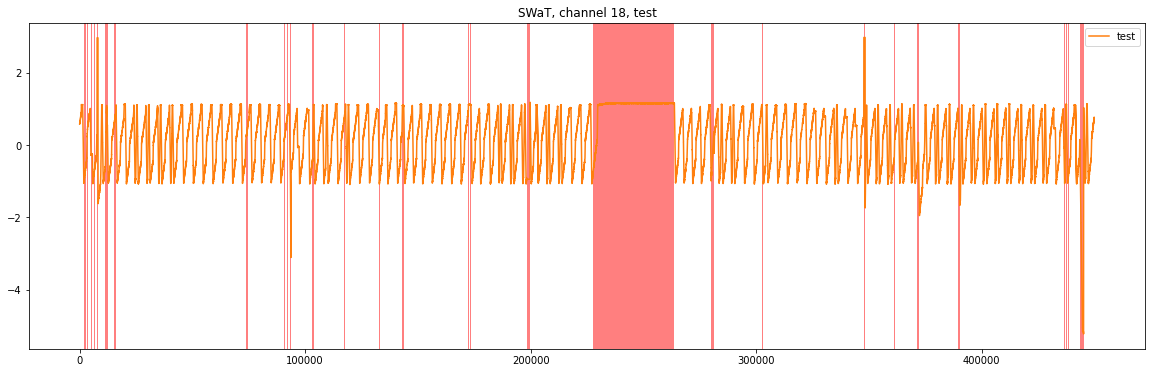

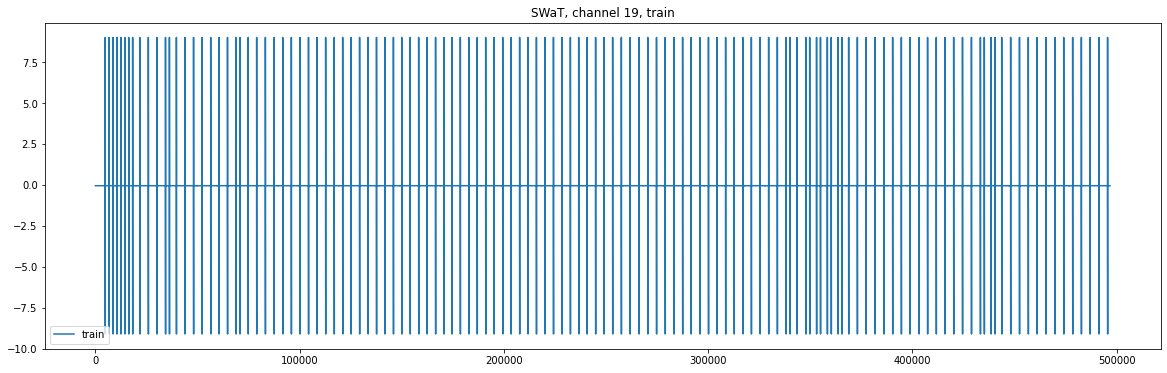

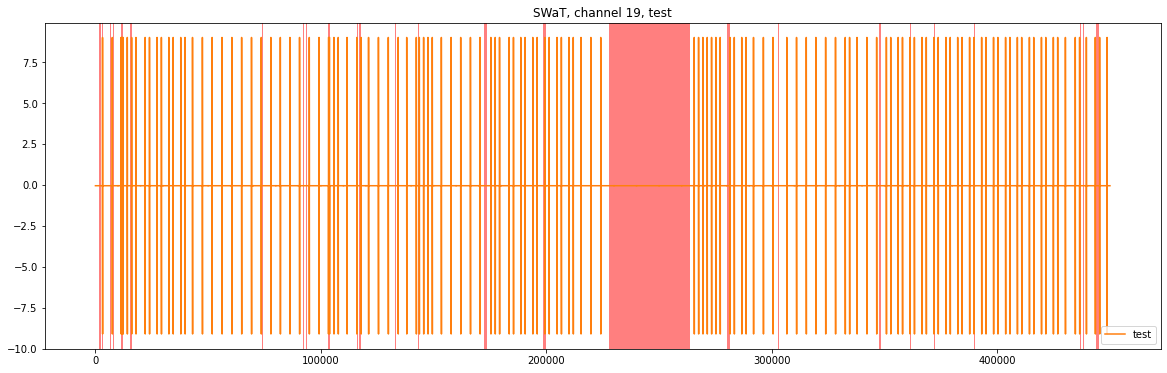

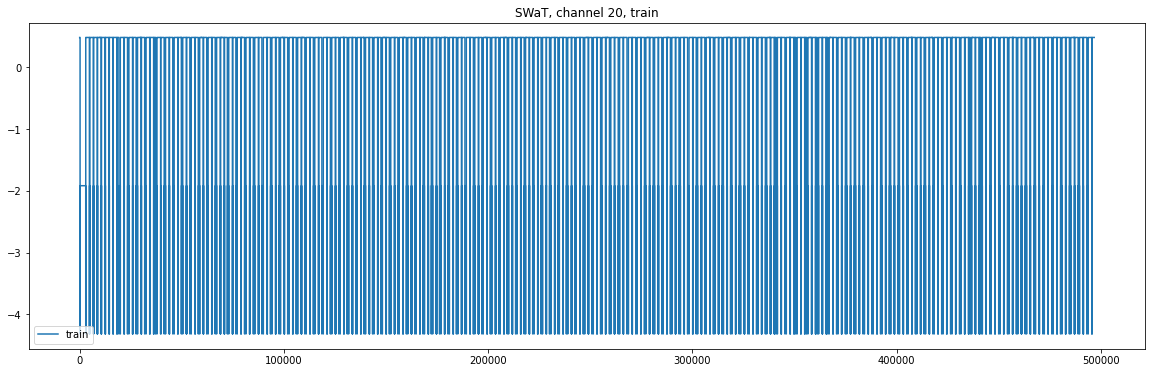

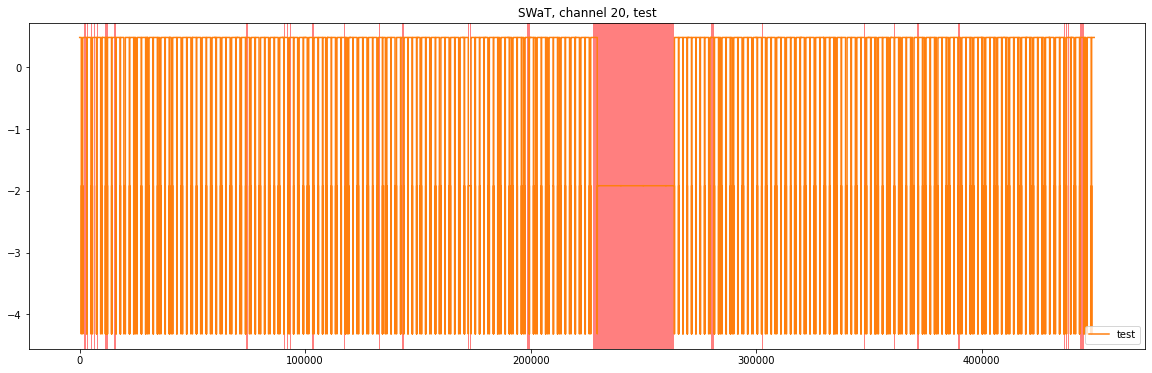

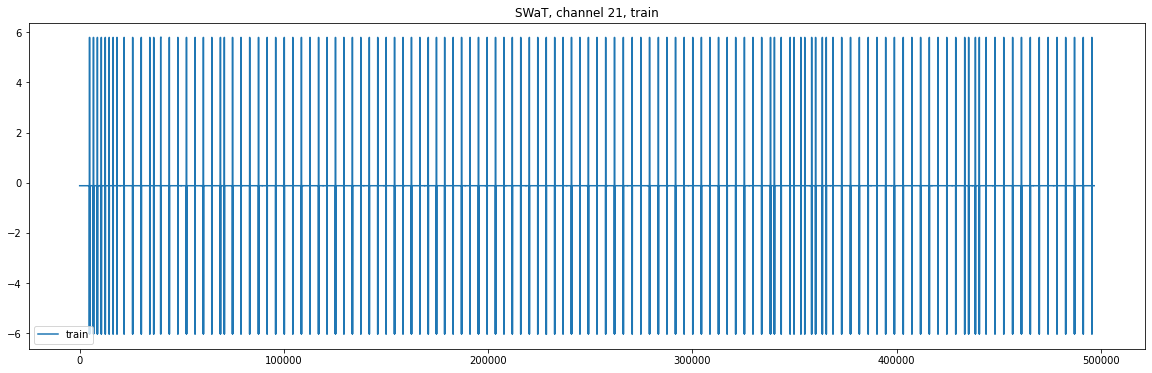

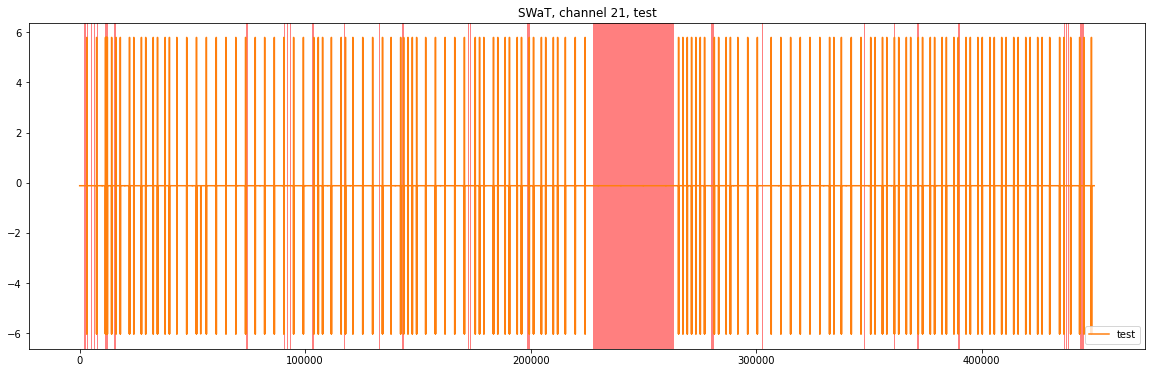

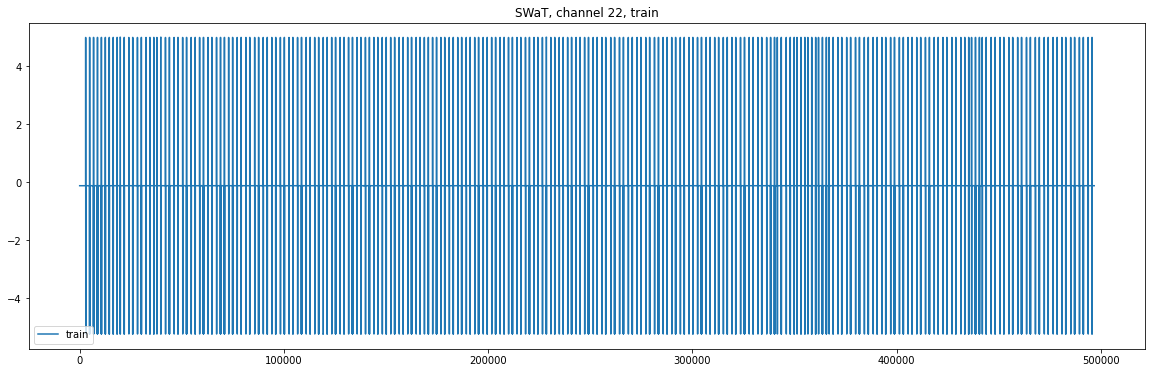

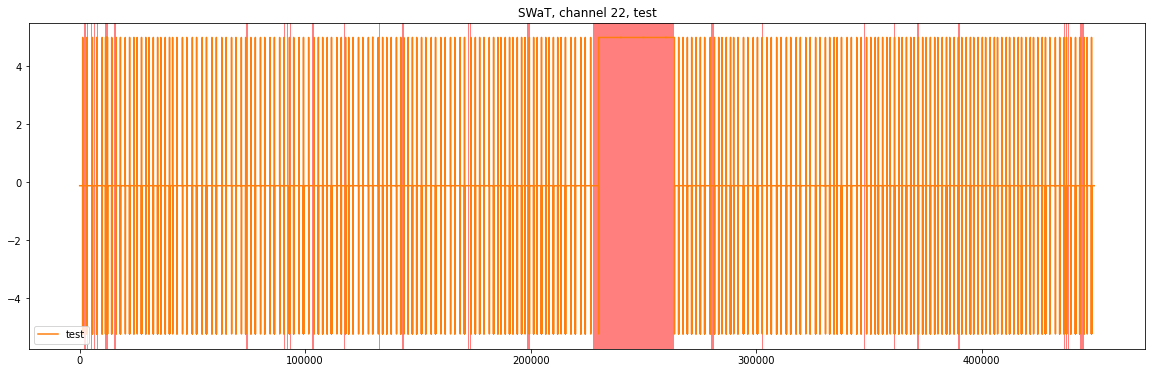

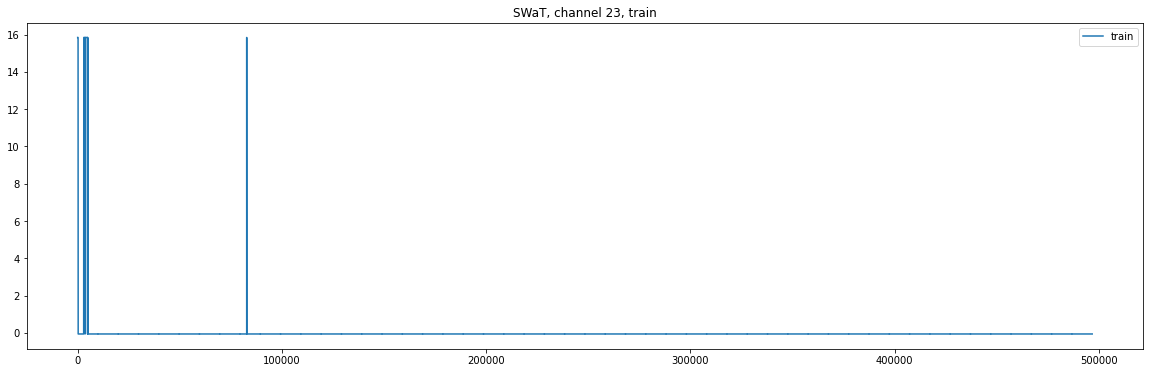

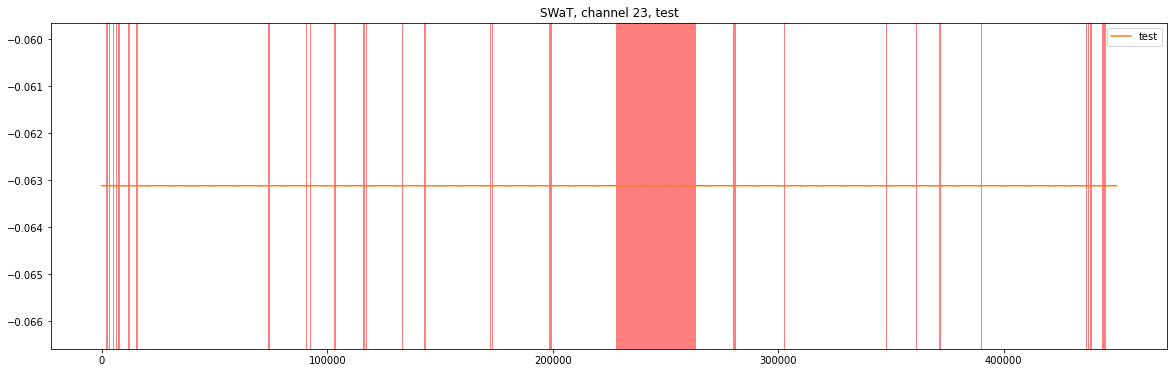

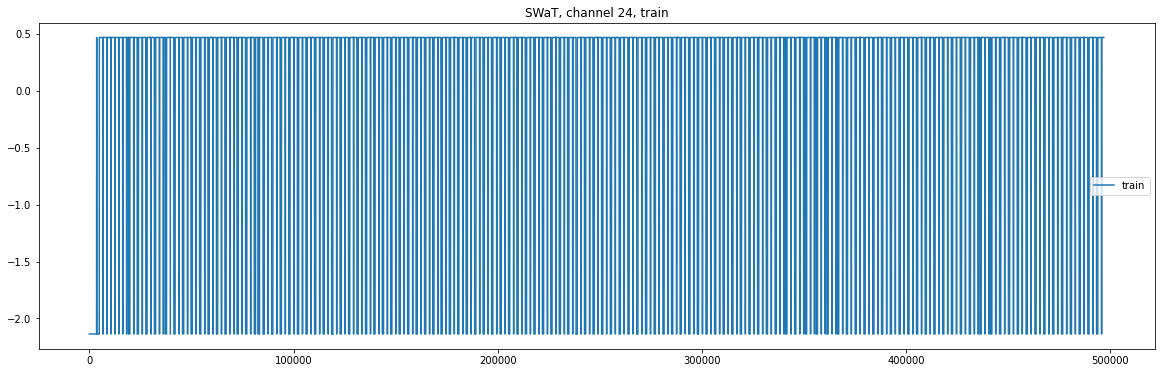

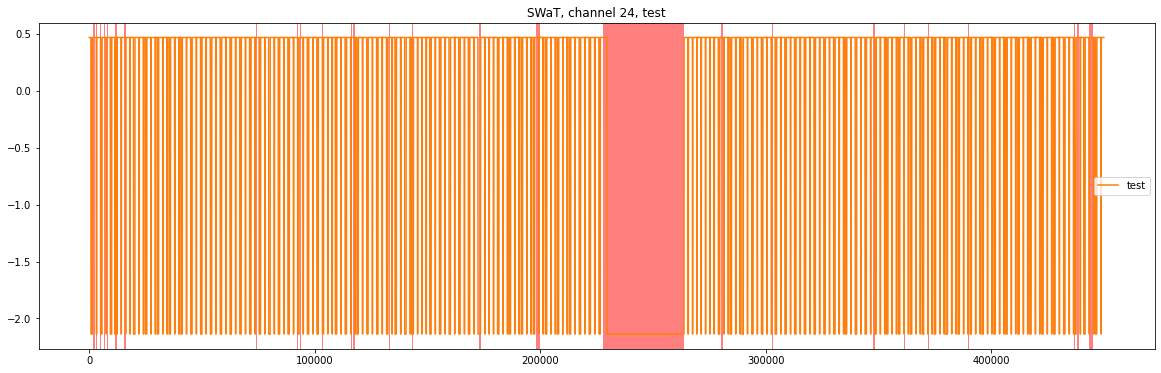

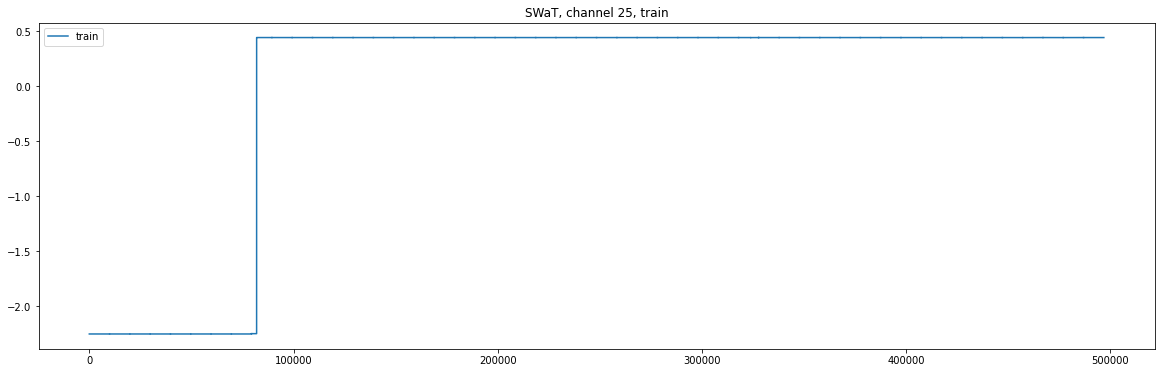

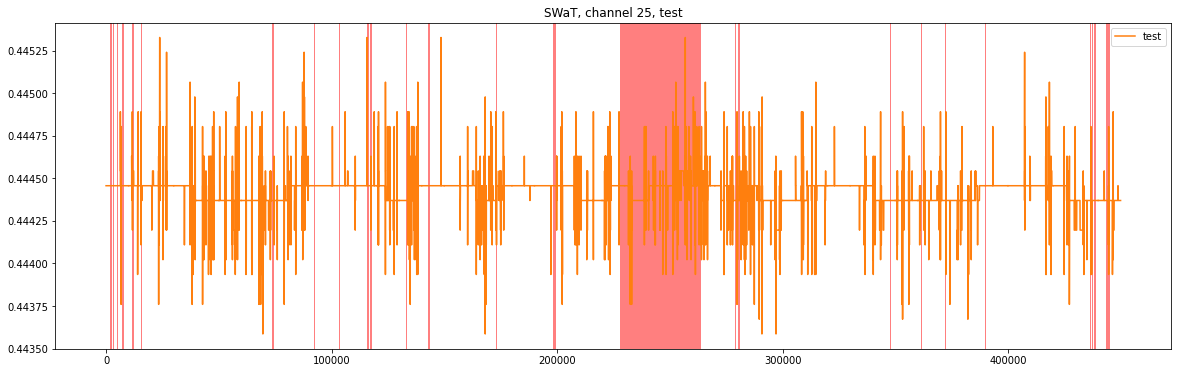

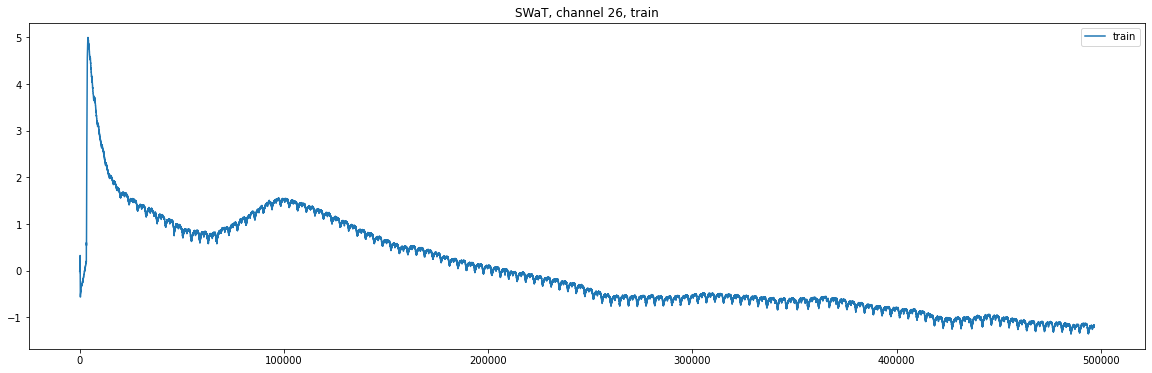

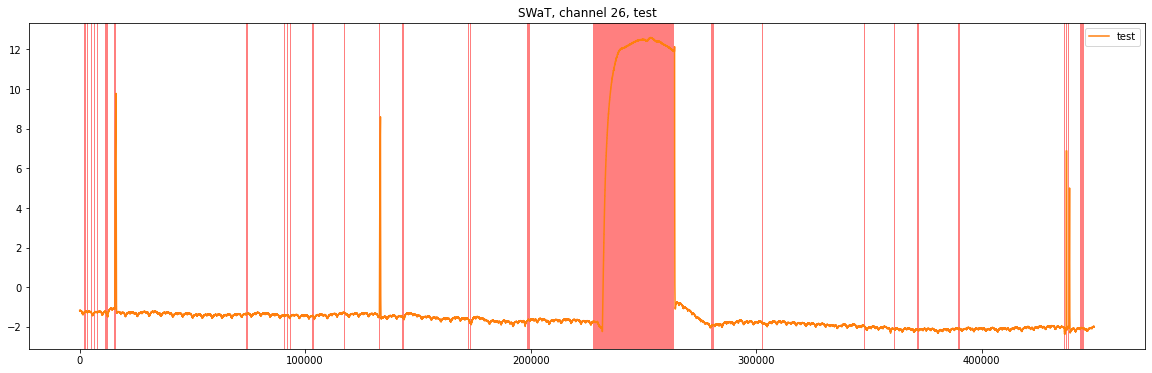

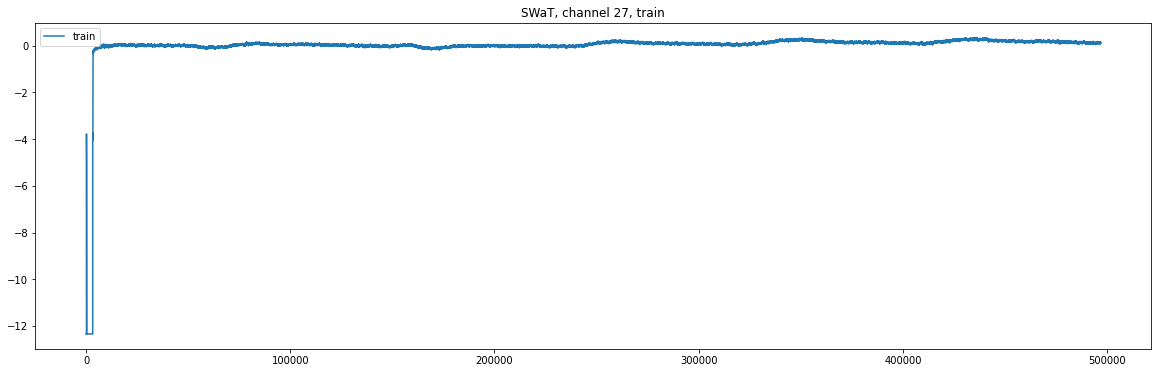

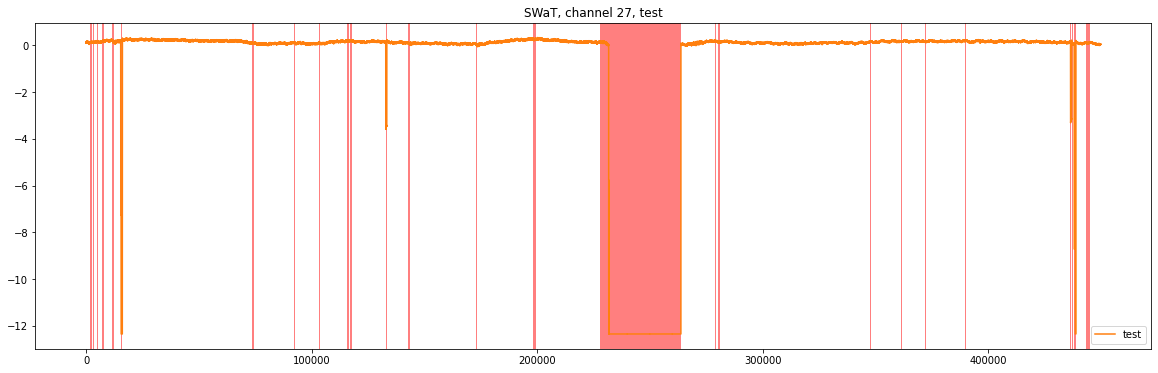

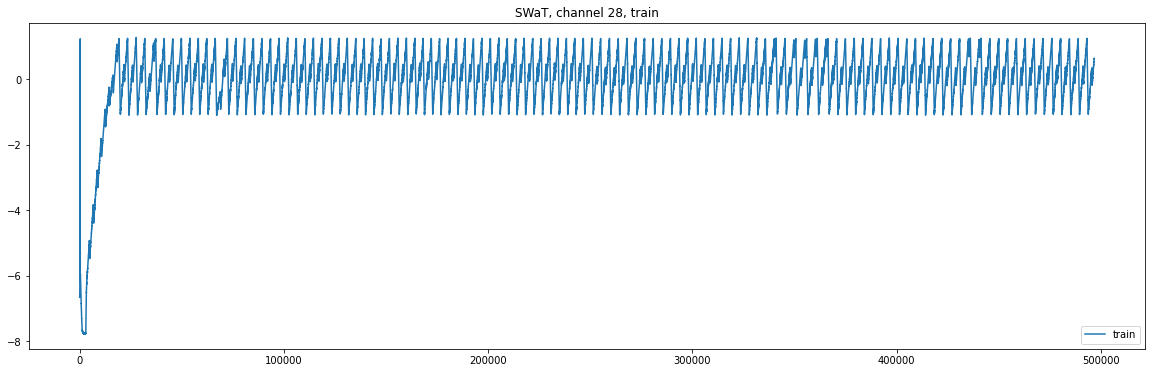

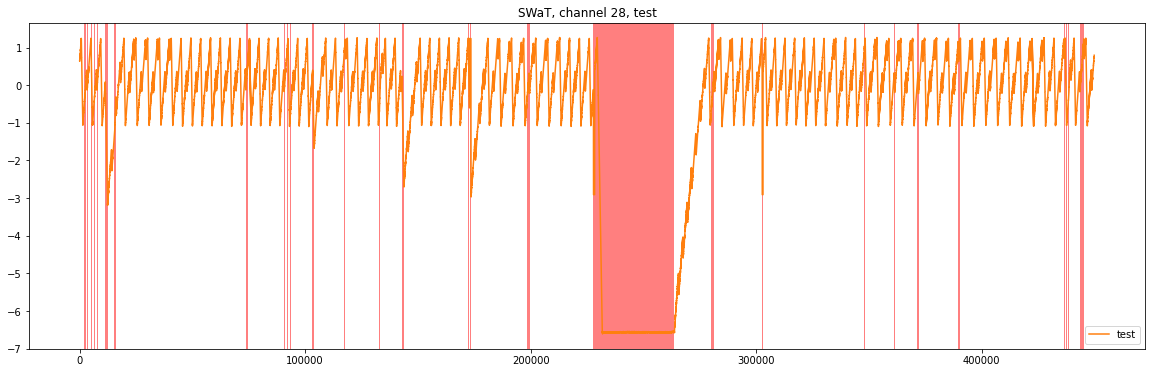

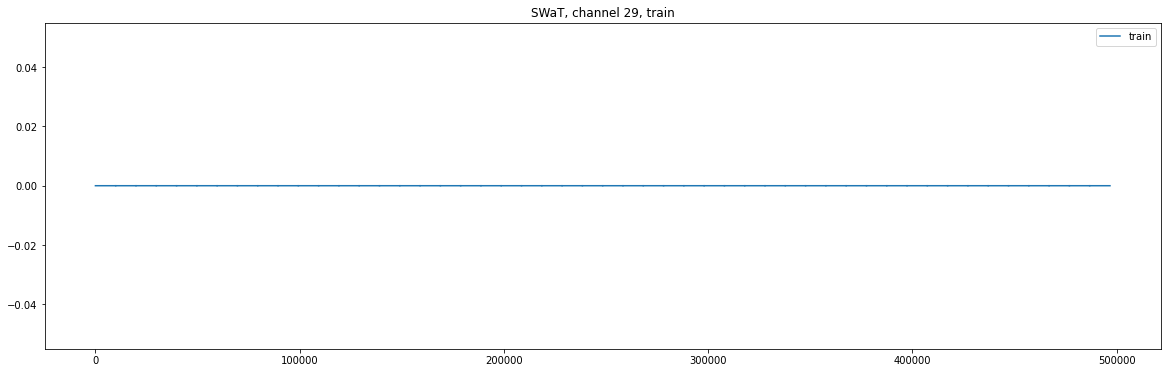

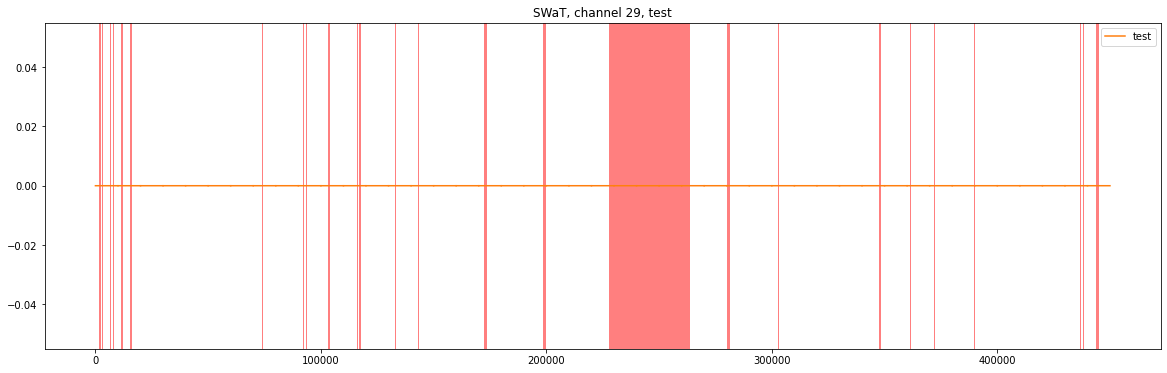

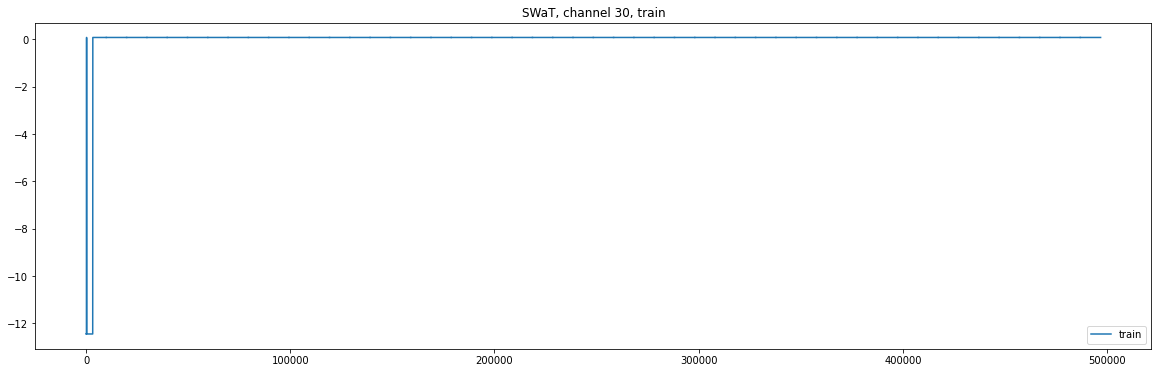

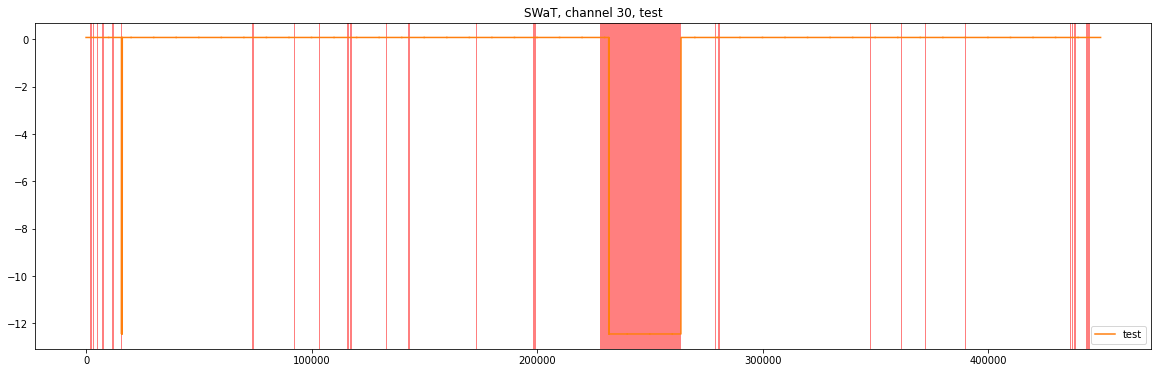

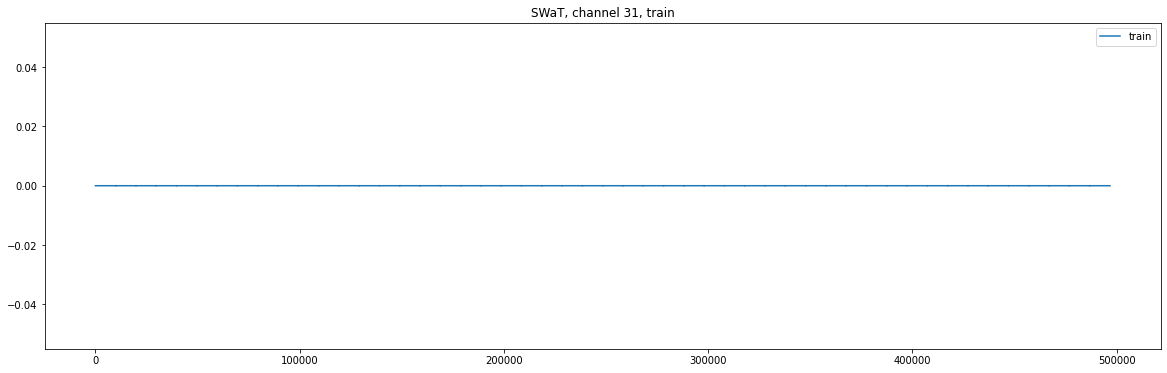

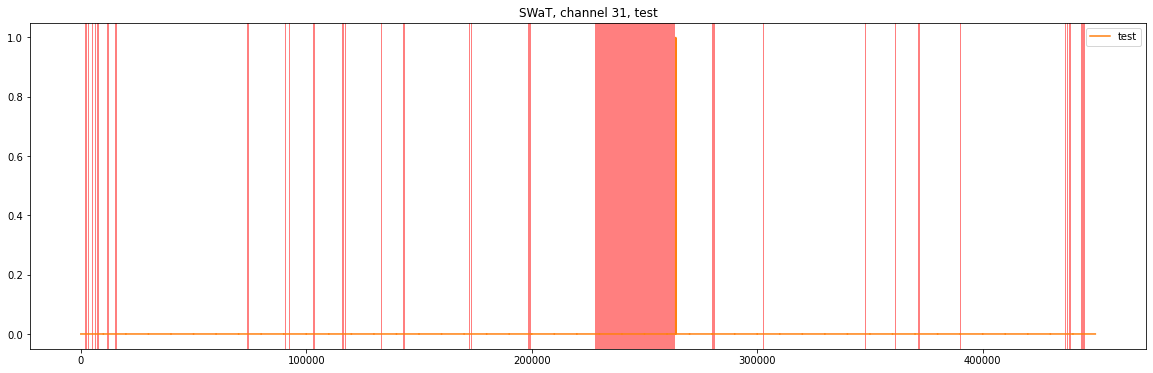

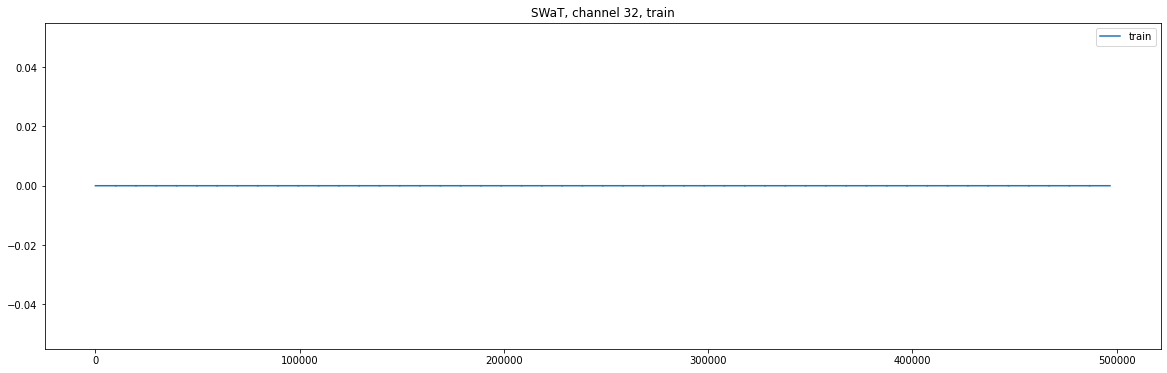

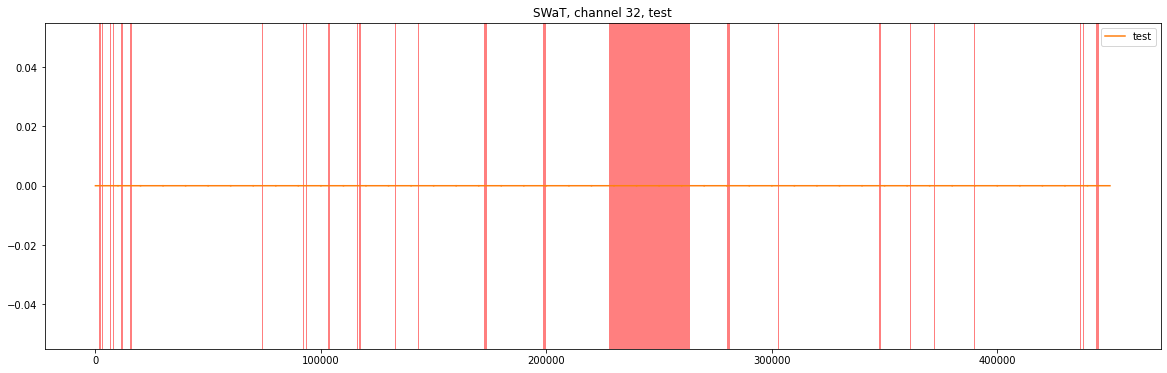

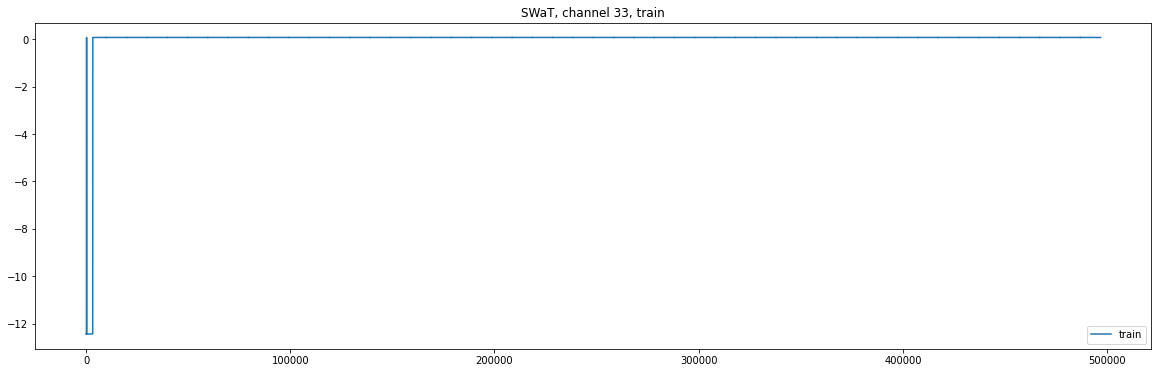

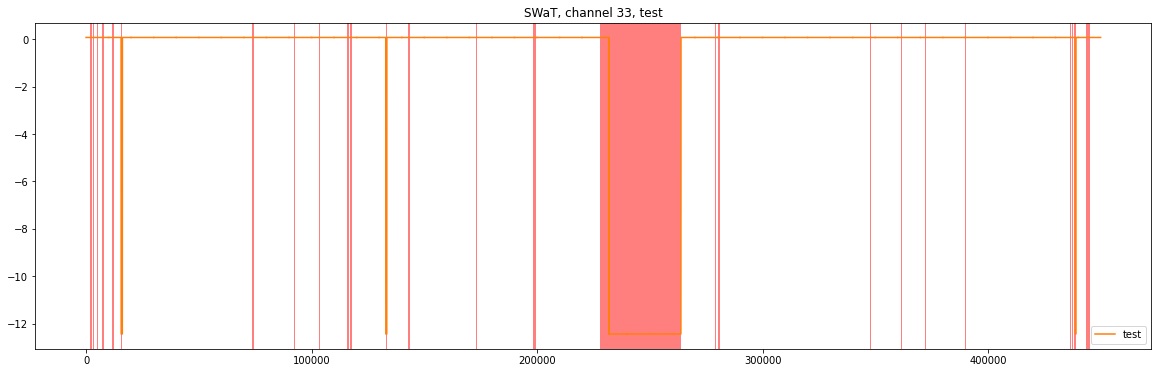

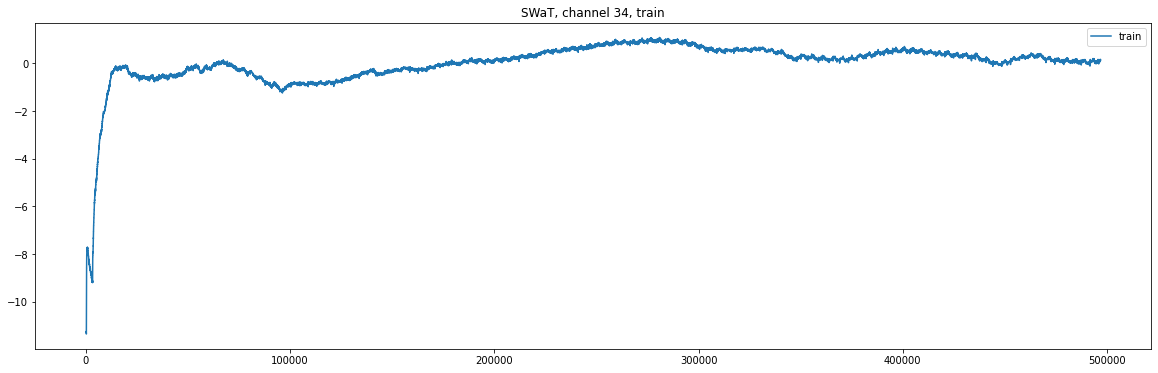

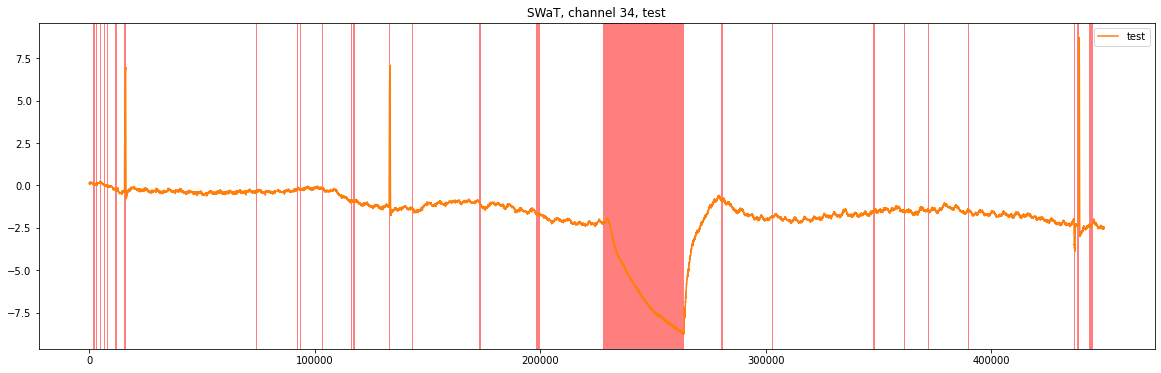

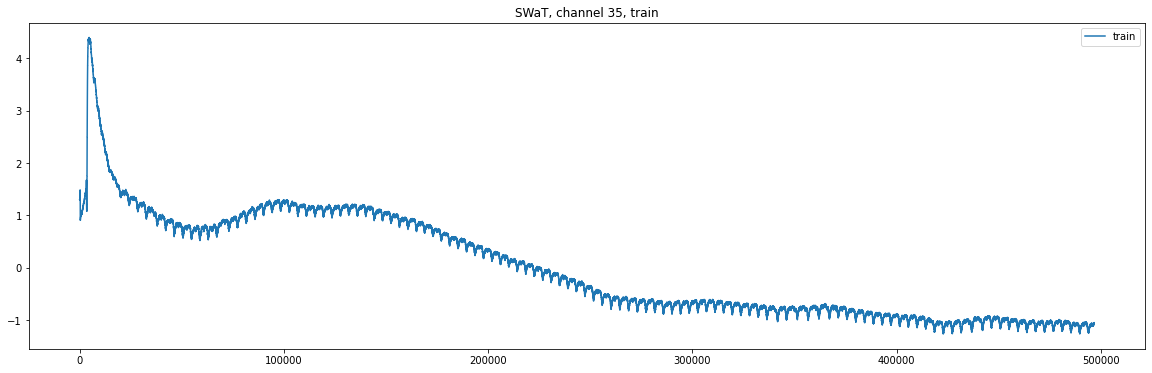

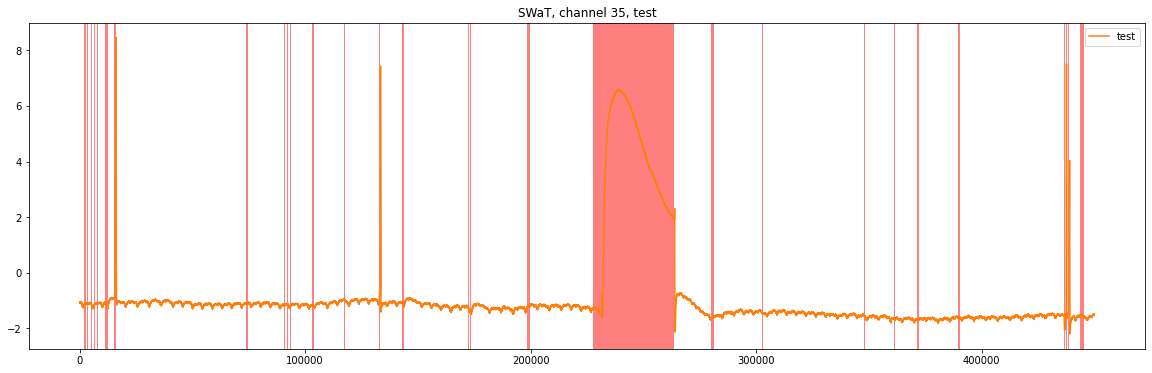

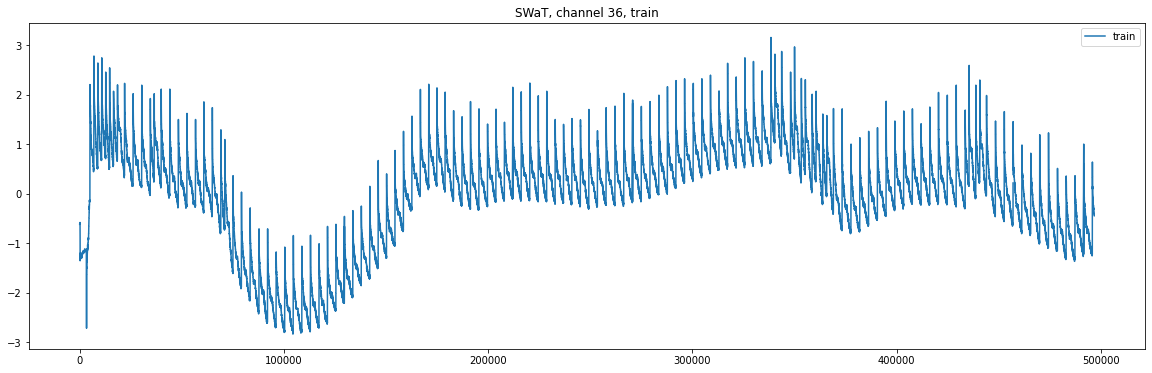

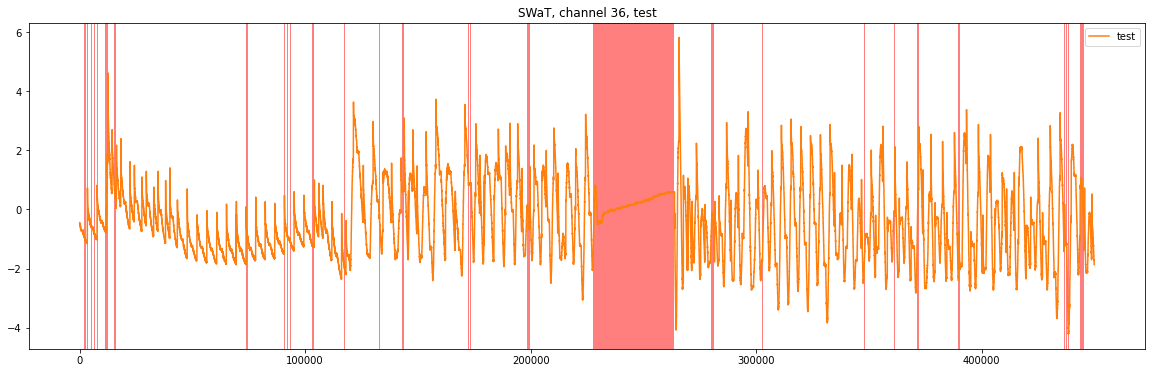

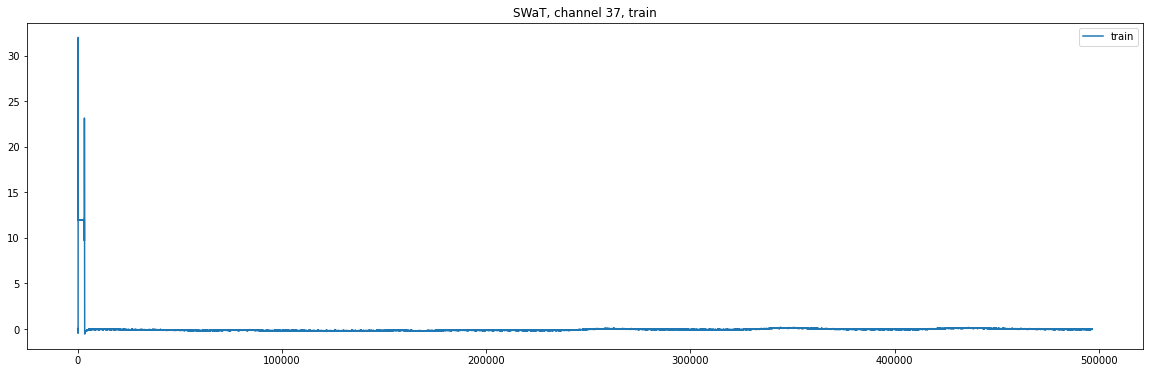

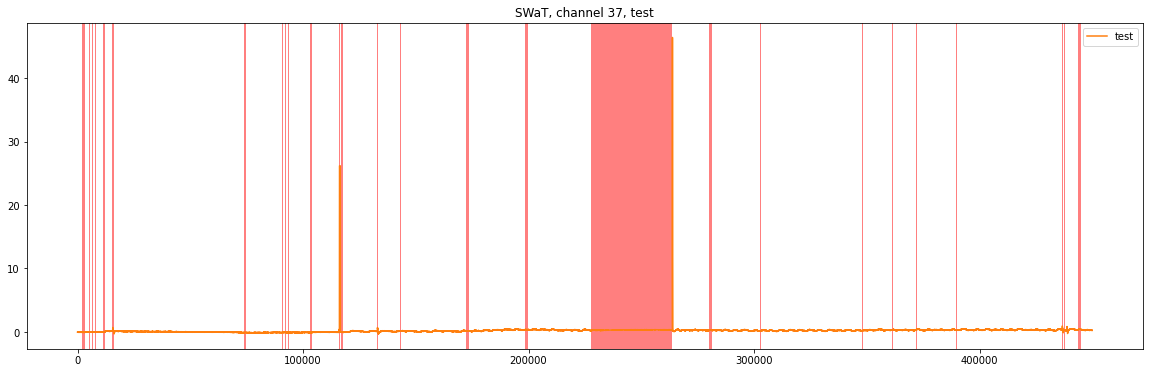

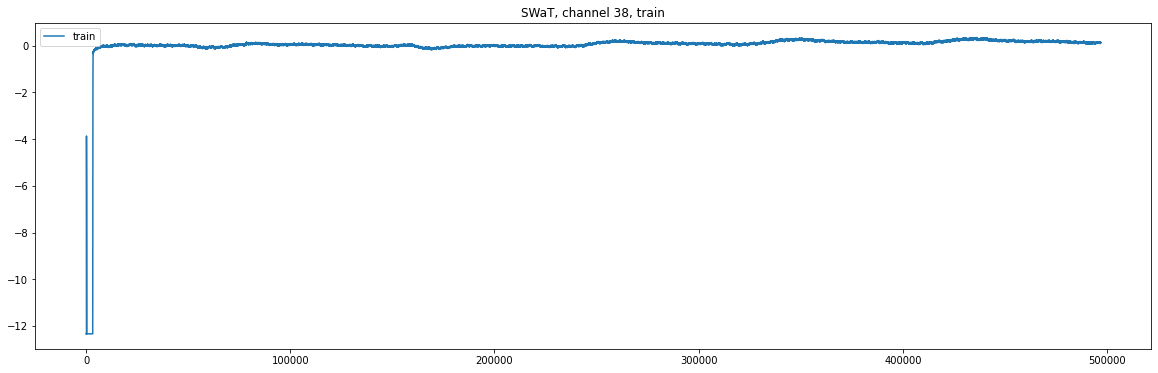

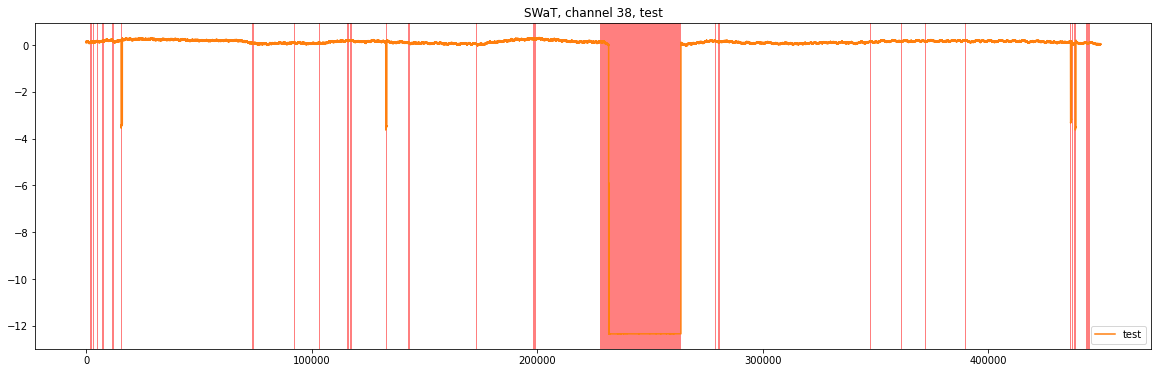

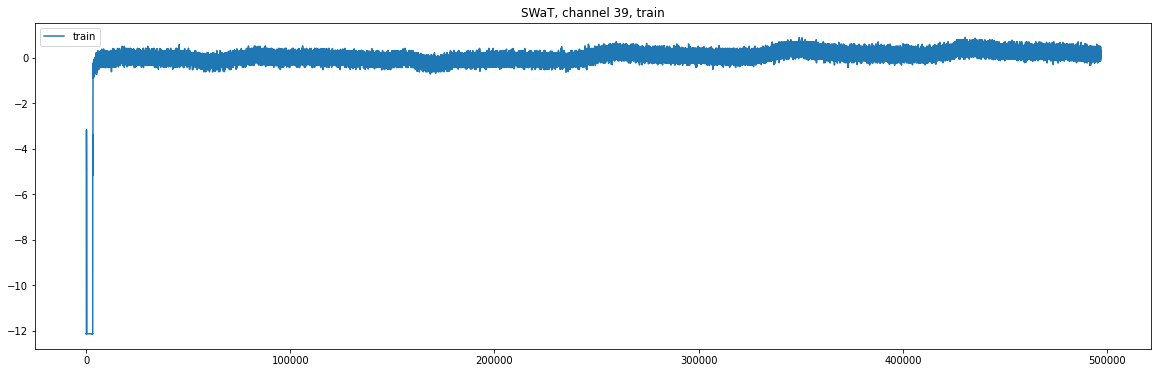

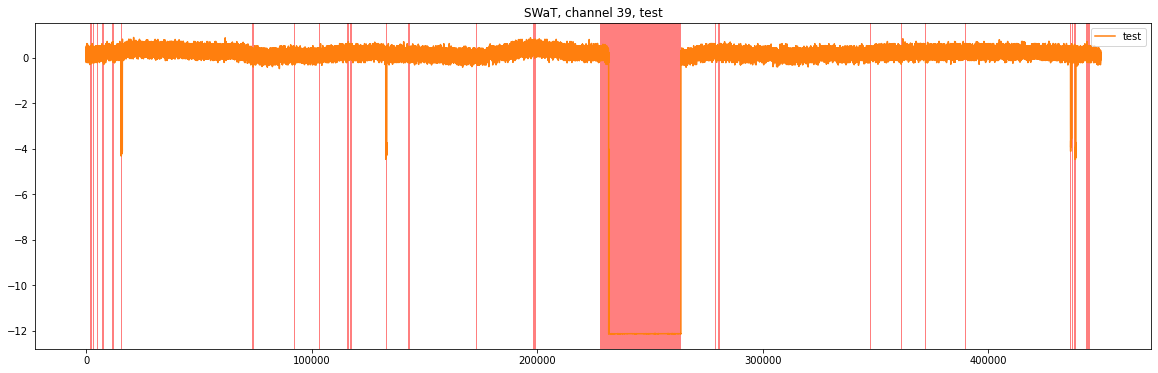

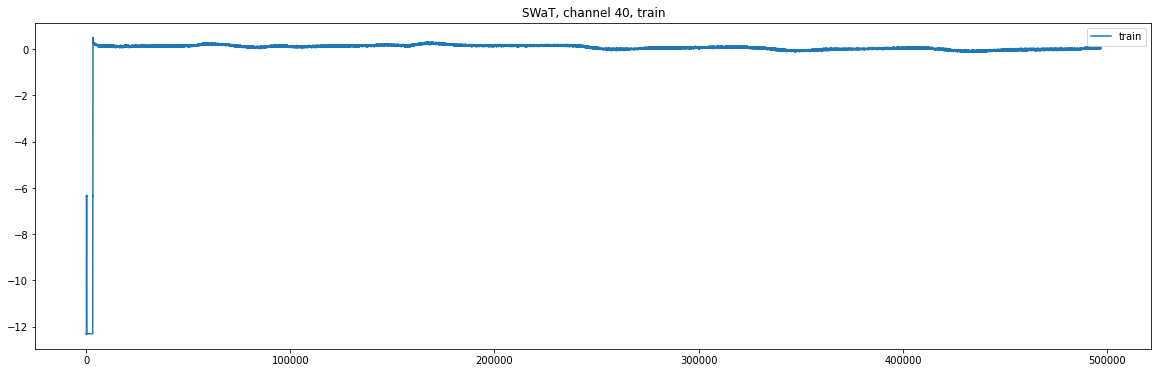

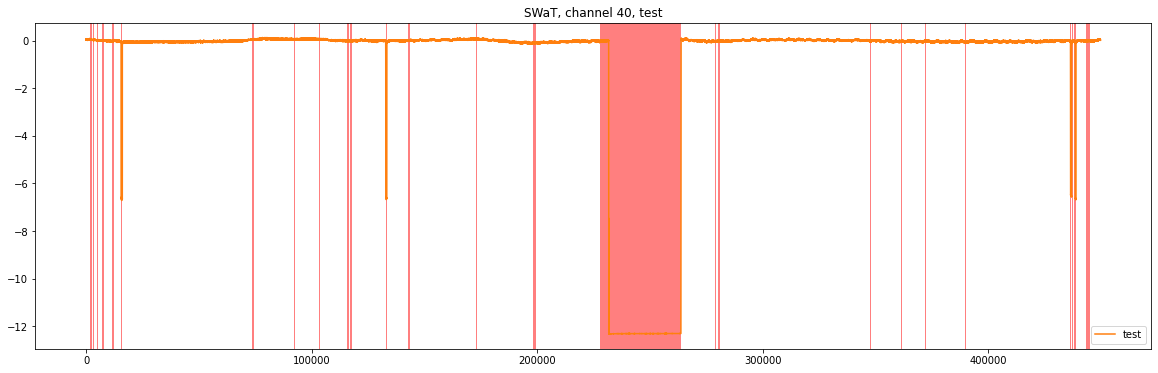

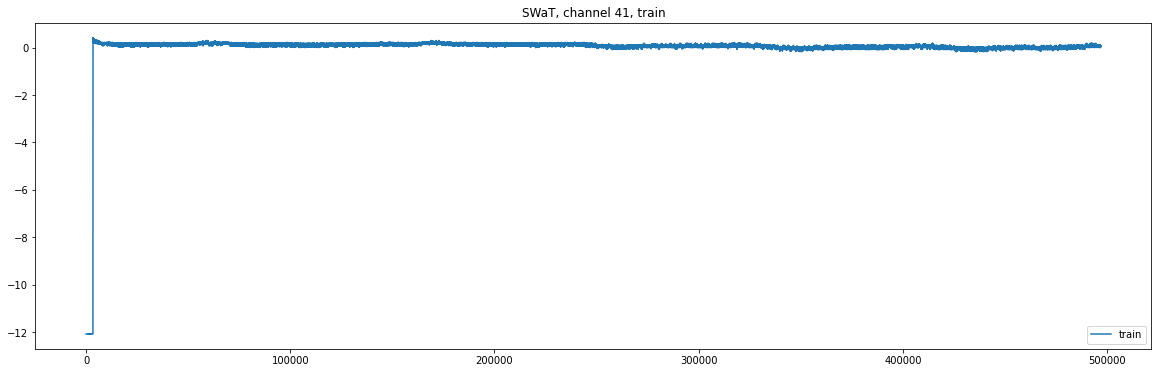

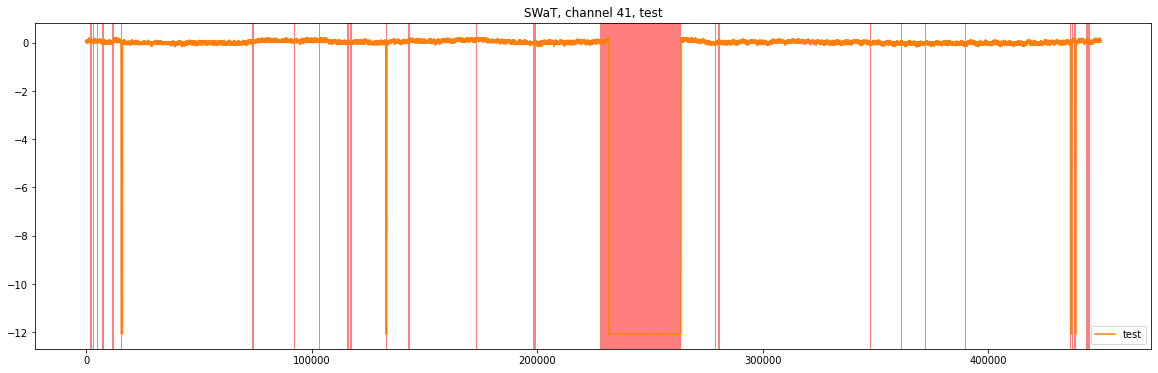

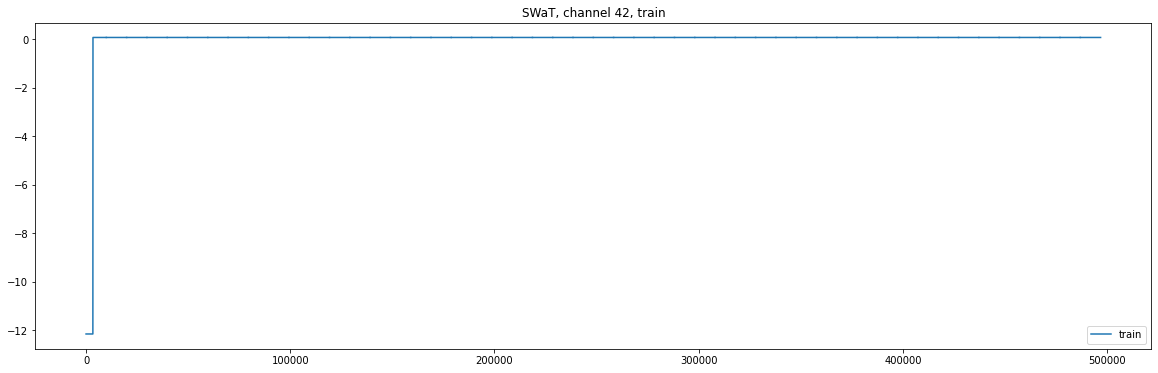

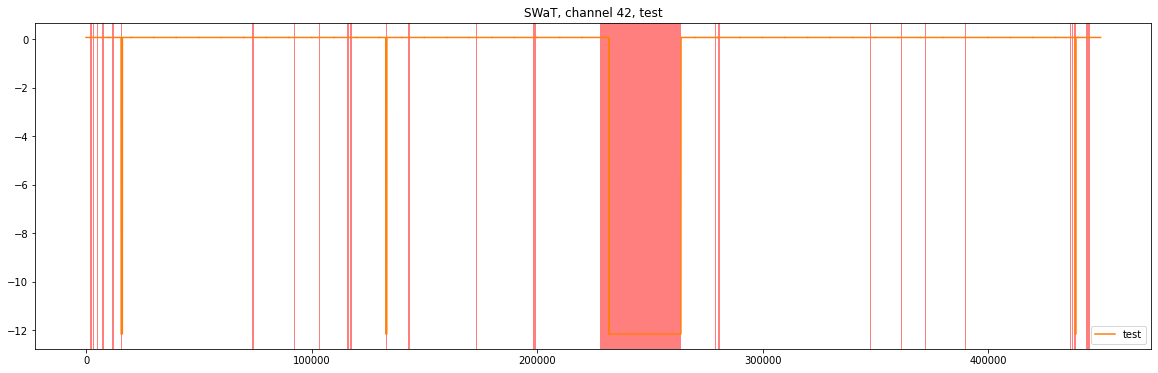

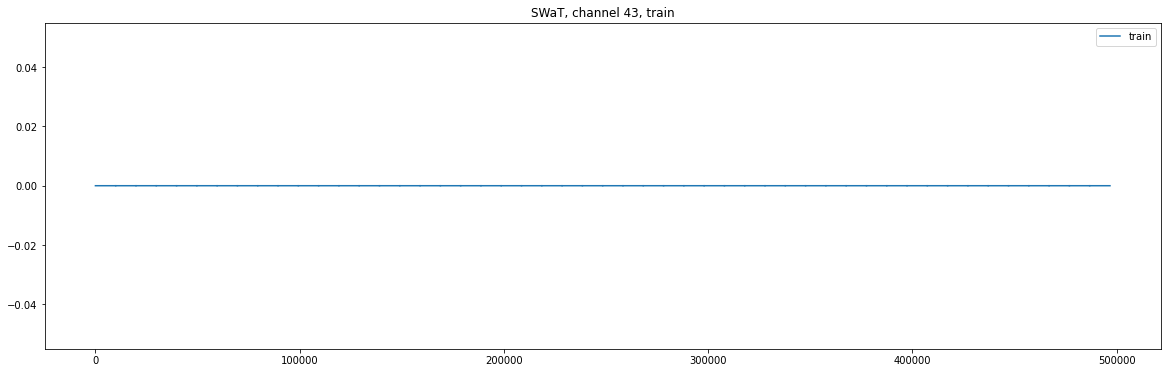

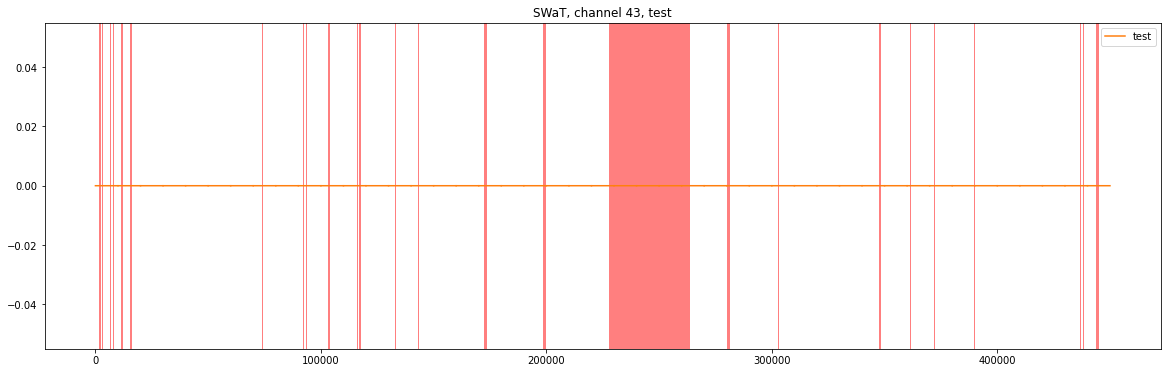

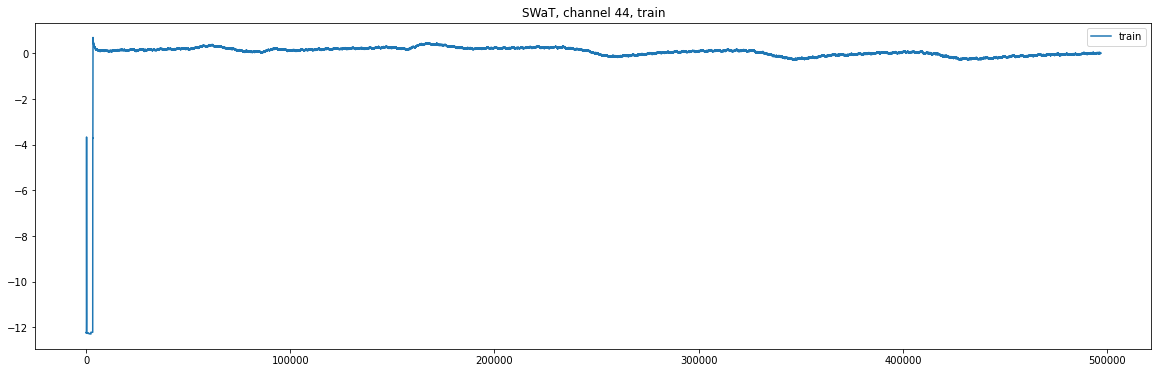

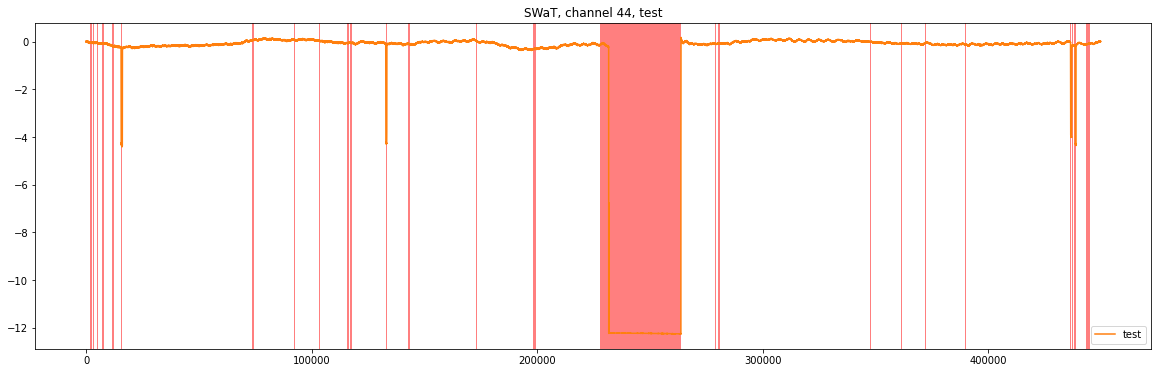

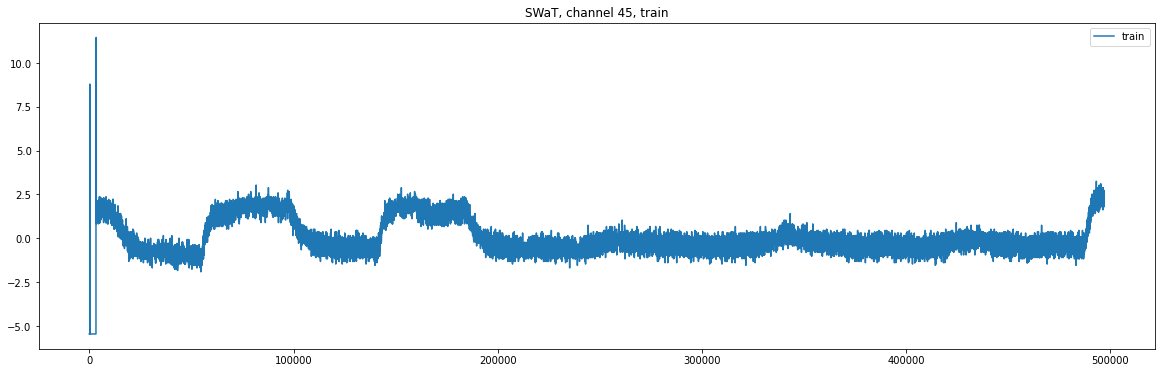

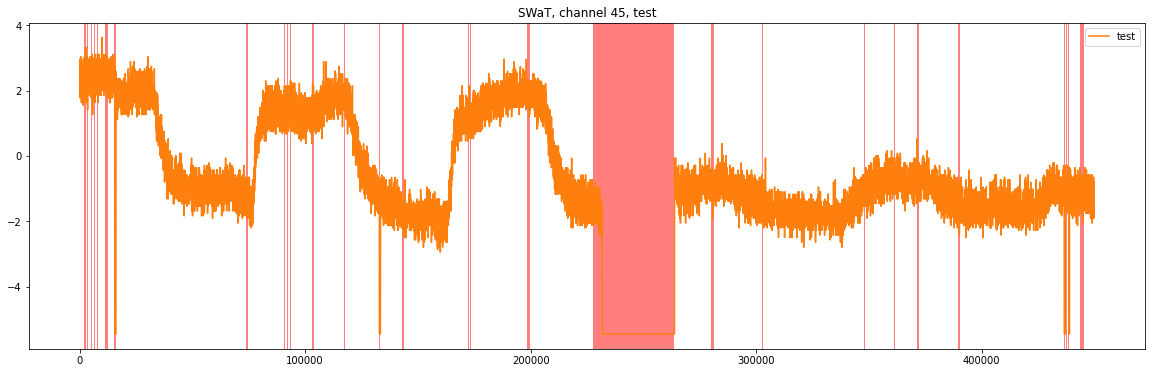

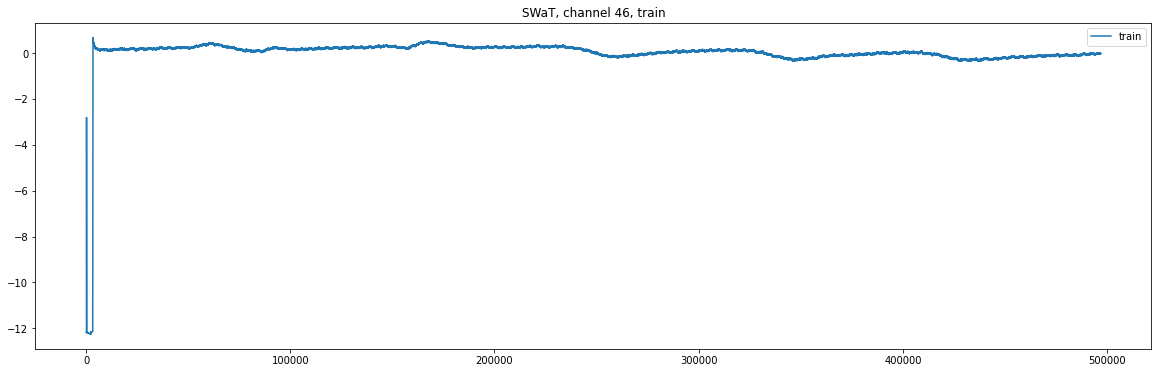

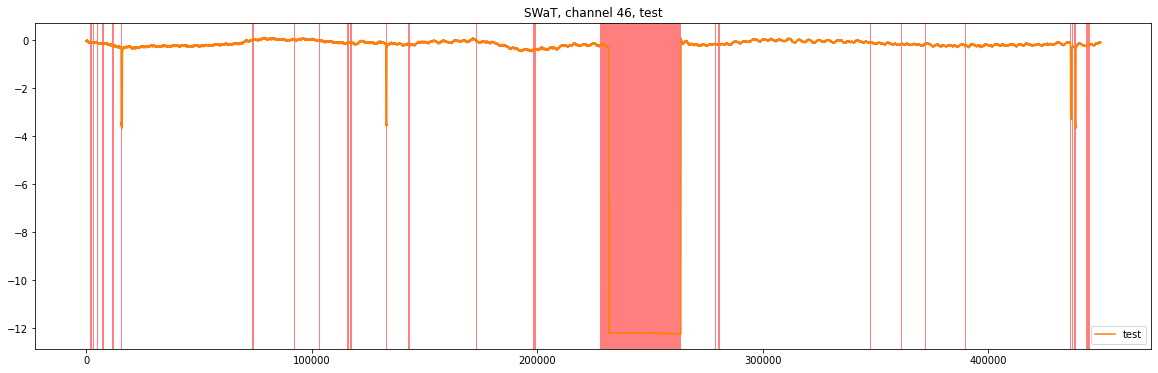

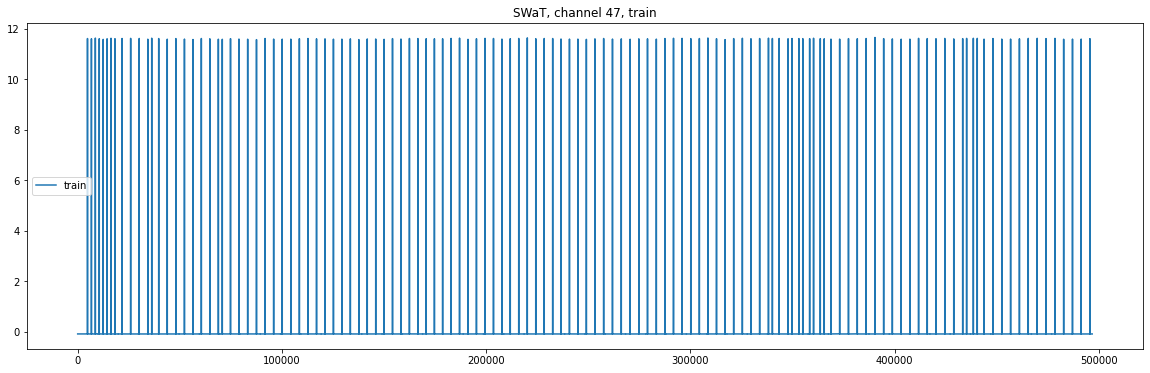

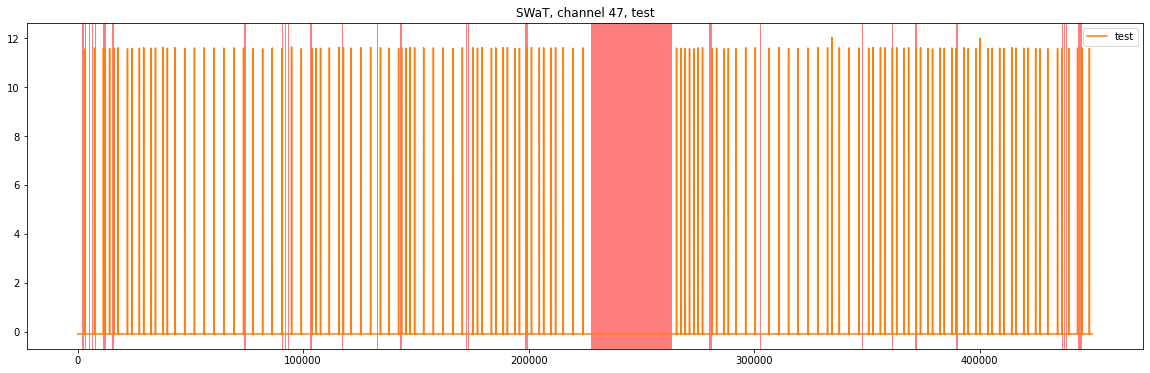

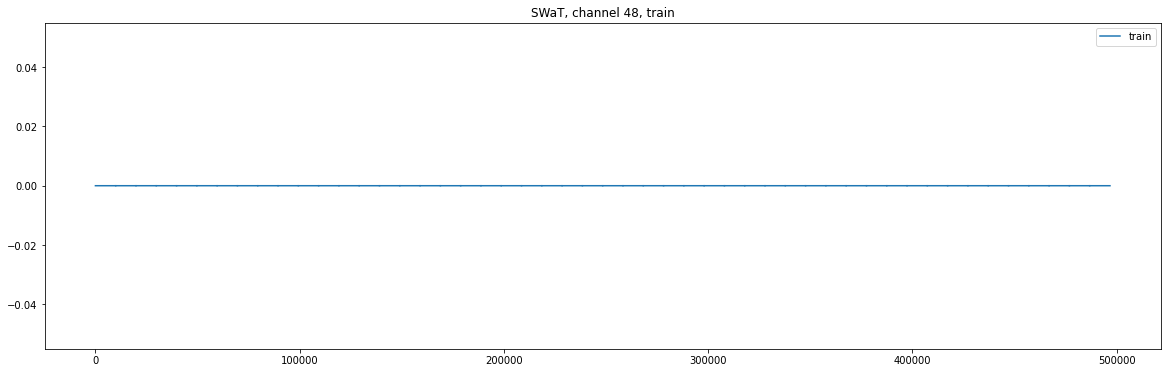

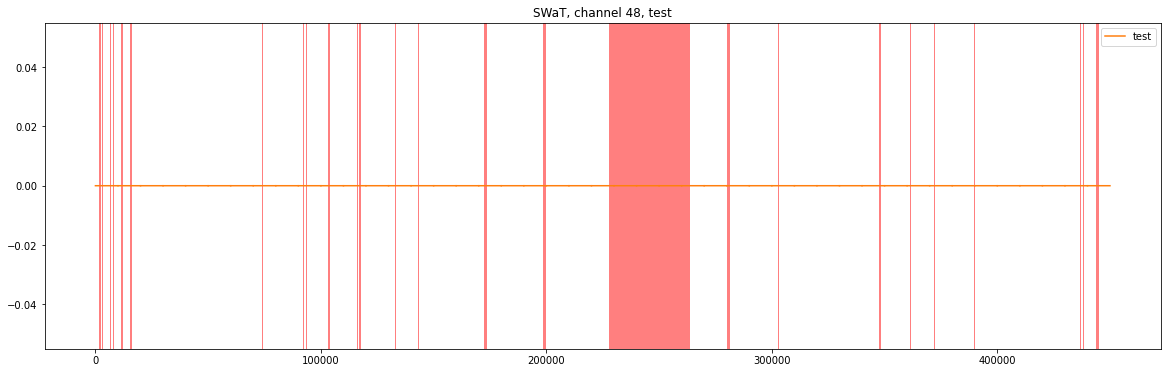

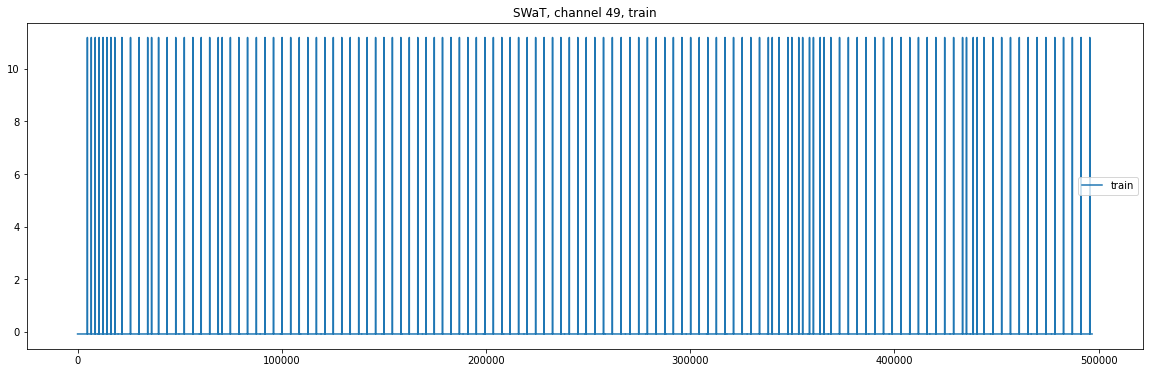

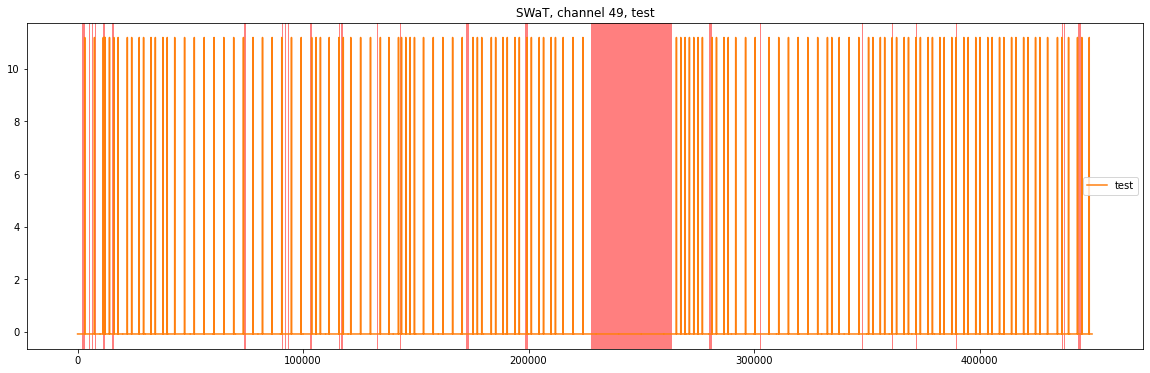

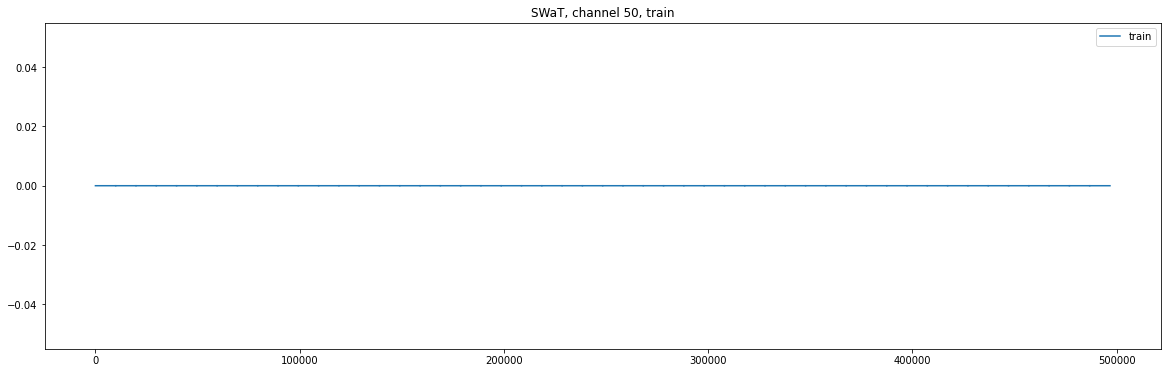

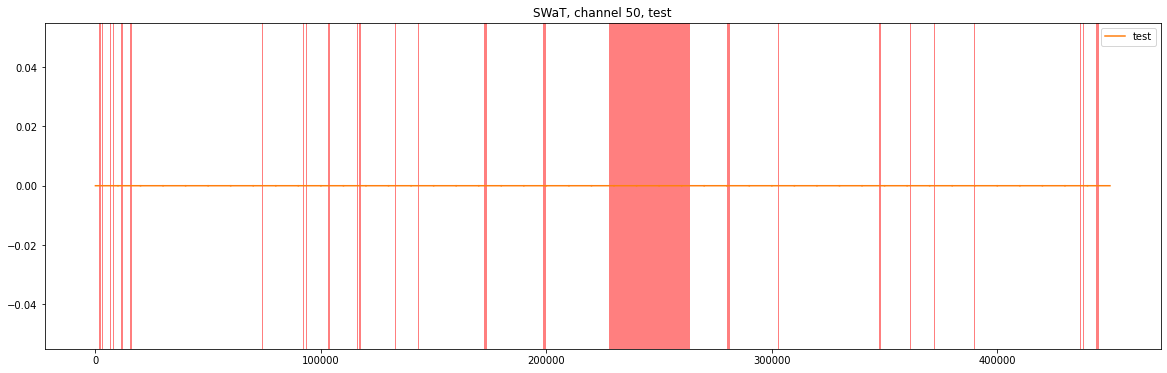

In [18]:
C = 7
for c in range(args.num_channels):
    plt.figure(figsize=(20, 6))
    plt.title(f"{args.dataset}, channel {c}, train")
    plt.plot(train_X[:, c], label="train", color="#1f77b4")
    plt.legend()
    plt.show()

    plt.figure(figsize=(20, 6))
    plt.title(f"{args.dataset}, channel {c}, test")
    plt.plot(test_X[:, c], label="test", color="#ff7f0e")
    plot_anomaly(plt, test_y)
    plt.legend()
    plt.show()